<h1>Stroke Prediction

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, average_precision_score, roc_curve, brier_score_loss, log_loss)
from sklearn.calibration import calibration_curve
from tensorflow import keras
from keras import layers, regularizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.isotonic import IsotonicRegression
from scipy.optimize import minimize
from xgboost import XGBClassifier
import seaborn as sns
import tensorflow as tf
import shap
import joblib
import optuna
import warnings
import pickle
warnings.filterwarnings('ignore')

In [5]:
tf.test.gpu_device_name()

''

In [6]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
License(s): copyright-authors
  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 53.6MB/s]


In [7]:
!unzip /content/stroke-prediction-dataset.zip -d /content/

Archive:  /content/stroke-prediction-dataset.zip
  inflating: /content/healthcare-dataset-stroke-data.csv  


In [8]:
!rm /content/stroke-prediction-dataset.zip

In [9]:
!ls /content/

healthcare-dataset-stroke-data.csv  sample_data


In [10]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv').drop('id', axis=1)
print(df.shape)
df.head()

(5110, 11)


gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

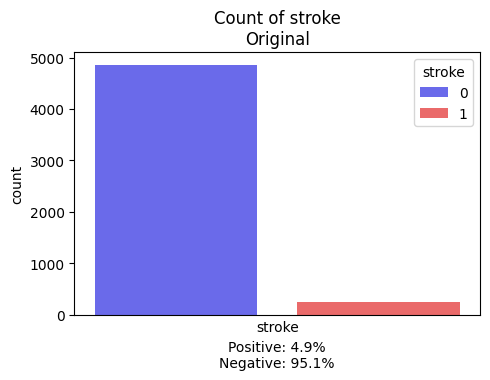

In [12]:
def plot_target_distributions(data_dict, figsize=(15, 4)):
  n_plots = len(data_dict)
  fig, axes = plt.subplots(1, n_plots, figsize = figsize)

  if n_plots == 1:
    axes = [axes]

  for ax, (keyword, (df, target_col)) in zip(axes, data_dict.items()):
    sns.countplot(data = df, x = target_col, hue = target_col, palette = 'seismic', legend = True, ax = ax)

    ax.set_title(f'Count of {target_col}\n{keyword}')
    ax.set_xticks([])

    pos = (df[target_col].mean() * 100)
    neg = 100 - pos
    ax.text(0.5, -0.2, f'Positive: {pos:.1f}%\nNegative: {neg:.1f}%', ha = 'center', transform = ax.transAxes)

  plt.tight_layout()
  plt.show()


plot_target_distributions({
    'Original': (df, 'stroke')
}, figsize = (5, 4))

In [11]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [13]:
cat_cols = [col for col in df.select_dtypes(include = ['object']).columns]
bi_cols = [col for col in df.select_dtypes(include = ['int64', 'float64']).columns if df[col].std() < 1 and col != 'stroke']
non_num_cols = cat_cols + bi_cols
non_num_cols

['gender',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'hypertension',
 'heart_disease']

In [14]:
encoder = OneHotEncoder(drop = 'first', sparse_output = False)
encoded_df = pd.DataFrame(encoder.fit_transform(df[cat_cols]), columns = encoder.get_feature_names_out(cat_cols))
encoded_df.head()

gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0          1.0           0.0               1.0                     0.0   
1          0.0           0.0               1.0                     0.0   
2          1.0           0.0               1.0                     0.0   
3          0.0           0.0               1.0                     0.0   
4          0.0           0.0               1.0                     0.0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                1.0                      0.0                 0.0   
1                0.0                      1.0                 0.0   
2                1.0                      0.0                 0.0   
3                1.0                      0.0                 0.0   
4                0.0                      1.0                 0.0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                   1.0                             1.0   
1                   0.0                             0.0   
2                   0.0                             0.0   
3                   1.0                             0.0   
4                   0.0                             0.0   

   smoking_status_never smoked  smoking_status_smokes  
0                          0.0                    0.0  
1                          1.0                    0.0  
2                          1.0                    0.0  
3                          0.0                    1.0  
4                          1.0                    0.0

In [15]:
df_update = pd.concat([df.drop(cat_cols, axis = 1), encoded_df], axis = 1)
df_update.head()

age  hypertension  heart_disease  avg_glucose_level   bmi  stroke  \
0  67.0             0              1             228.69  36.6       1   
1  61.0             0              0             202.21   NaN       1   
2  80.0             0              1             105.92  32.5       1   
3  49.0             0              0             171.23  34.4       1   
4  79.0             1              0             174.12  24.0       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0          1.0           0.0               1.0                     0.0   
1          0.0           0.0               1.0                     0.0   
2          1.0           0.0               1.0                     0.0   
3          0.0           0.0               1.0                     0.0   
4          0.0           0.0               1.0                     0.0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                1.0                      0.0                 0.0   
1                0.0                      1.0                 0.0   
2                1.0                      0.0                 0.0   
3                1.0                      0.0                 0.0   
4                0.0                      1.0                 0.0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                   1.0                             1.0   
1                   0.0                             0.0   
2                   0.0                             0.0   
3                   1.0                             0.0   
4                   0.0                             0.0   

   smoking_status_never smoked  smoking_status_smokes  
0                          0.0                    0.0  
1                          1.0                    0.0  
2                          1.0                    0.0  
3                          0.0                    1.0  
4                          1.0                    0.0

In [16]:
imputation_features = ['age', 'gender_Male', 'gender_Other', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
imputer = IterativeImputer(random_state = 42, max_iter = 10, n_nearest_features = 6)

imputed_value = imputer.fit_transform(df_update[imputation_features])
df_update['bmi'] = imputed_value[:, -1]

In [17]:
df_update.head()

age  hypertension  heart_disease  avg_glucose_level        bmi  stroke  \
0  67.0             0              1             228.69  36.600000       1   
1  61.0             0              0             202.21  32.583436       1   
2  80.0             0              1             105.92  32.500000       1   
3  49.0             0              0             171.23  34.400000       1   
4  79.0             1              0             174.12  24.000000       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0          1.0           0.0               1.0                     0.0   
1          0.0           0.0               1.0                     0.0   
2          1.0           0.0               1.0                     0.0   
3          0.0           0.0               1.0                     0.0   
4          0.0           0.0               1.0                     0.0   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                1.0                      0.0                 0.0   
1                0.0                      1.0                 0.0   
2                1.0                      0.0                 0.0   
3                1.0                      0.0                 0.0   
4                0.0                      1.0                 0.0   

   Residence_type_Urban  smoking_status_formerly smoked  \
0                   1.0                             1.0   
1                   0.0                             0.0   
2                   0.0                             0.0   
3                   1.0                             0.0   
4                   0.0                             0.0   

   smoking_status_never smoked  smoking_status_smokes  
0                          0.0                    0.0  
1                          1.0                    0.0  
2                          1.0                    0.0  
3                          0.0                    1.0  
4                          1.0                    0.0

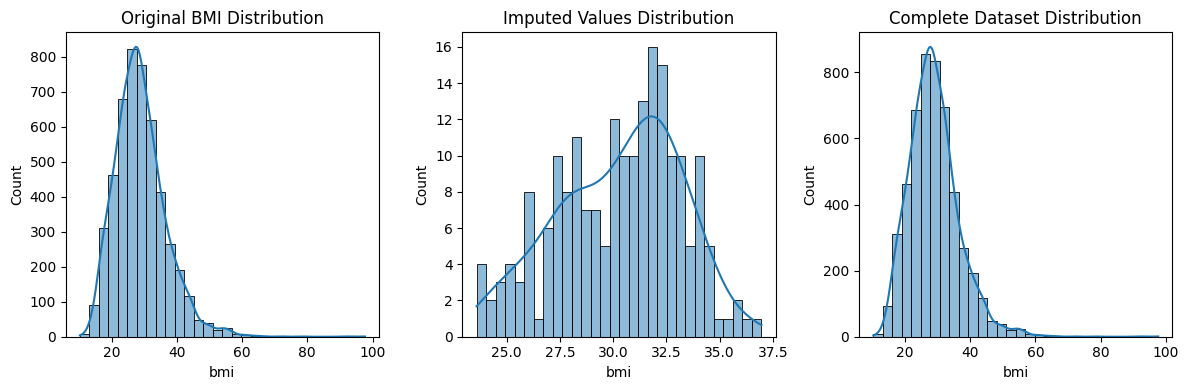


Original BMI Statistics:
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

Imputed BMI Statistics:
count    5110.000000
mean       28.947044
std         7.723927
min        10.300000
25%        23.800000
50%        28.200000
75%        33.000000
max        97.600000
Name: bmi, dtype: float64


In [18]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df['bmi'].dropna(), bins = 30, kde = True)
plt.title('Original BMI Distribution')

plt.subplot(1, 3, 2)
mask = df['bmi'].isnull()
sns.histplot(df_update.loc[mask, 'bmi'], bins = 30, kde = True)
plt.title('Imputed Values Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df_update['bmi'], bins = 30, kde = True)
plt.title('Complete Dataset Distribution')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nOriginal BMI Statistics:")
print(df['bmi'].describe())
print("\nImputed BMI Statistics:")
print(df_update['bmi'].describe())

In [19]:
df_update['bmi_imputed'] = df['bmi'].isnull().astype(int)

if 'bmi_imputed' in df_update.columns:
    imputed_mean = df_update.loc[df_update['bmi_imputed'] == 1, 'bmi'].mean()
    imputed_median = df_update.loc[df_update['bmi_imputed'] == 1, 'bmi'].median()
    imputed_std = df_update.loc[df_update['bmi_imputed'] == 1, 'bmi'].std()

print(f"Mean of imputed BMI: {imputed_mean}")
print(f"Median of imputed BMI: {imputed_median}")
print(f"Standard Deviation of imputed BMI: {imputed_std}")

Mean of imputed BMI: 30.261165276062066
Median of imputed BMI: 30.677686438508946
Standard Deviation of imputed BMI: 2.8983358438713283


In [20]:
df_update.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  gender_Male  gender_Other  ever_married_Yes  \
count  5110.000000  5110.000000  5110.000000   5110.000000       5110.000000   
mean     28.947044     0.048728     0.413894      0.000196          0.656164   
std       7.723927     0.215320     0.492578      0.013989          0.475034   
min      10.300000     0.000000     0.000000      0.000000          0.000000   
25%      23.800000     0.000000     0.000000      0.000000          0.000000   
50%      28.200000     0.000000     0.000000      0.000000          1.000000   
75%      33.000000     0.000000     1.000000      0.000000          1.000000   
max      97.600000     1.000000     1.000000      1.000000          1.000000   

       work_type_Never_worked  work_type_Private  work_type_Self-employed  \
count             5110.000000        5110.000000              5110.000000   
mean                 0.004305           0.572407                 0.160274   
std                  0.065480           0.494778                 0.366896   
min                  0.000000           0.000000                 0.000000   
25%                  0.000000           0.000000                 0.000000   
50%                  0.000000           1.000000                 0.000000   
75%                  0.000000           1.000000                 0.000000   
max                  1.000000           1.000000                 1.000000   

       work_type_children  Residence_type_Urban  \
count         5110.000000           5110.000000   
mean             0.134442              0.508023   
std              0.341160              0.499985   
min              0.000000              0.000000   
25%              0.000000              0.000000   
50%              0.000000              1.000000   
75%              0.000000              1.000000   
max              1.000000              1.000000   

       smoking_status_formerly smoked  smoking_status_never smoked  \
count                     5110.000000                  5110.000000   
mean                         0.173190                     0.370254   
std                          0.378448                     0.482920   
min                          0.000000                     0.000000   
25%                          0.000000                     0.000000   
50%                          0.000000                     0.000000   
75%                          0.000000                     1.000000   
max                          1.000000                     1.000000   

       smoking_status_smokes  bmi_imputed  
count            5110.000000  5110.000000  
mean                0.154403     0.039335  
std                 0.361370     0.194409  
min                 0.000000     0.000000  
25%                 0.000000     0.000000  
50%                 0.000000     0.000000  
75%                 0.000000     0.000000  
max                 1.000000     1.000000

In [21]:
num_cols = [col for col in df_update.columns if df_update[col].std() > 1]
num_cols

['age', 'avg_glucose_level', 'bmi']

In [22]:
df_pos = df_update[df_update['stroke'] == 1]
df_pos.shape

(249, 18)

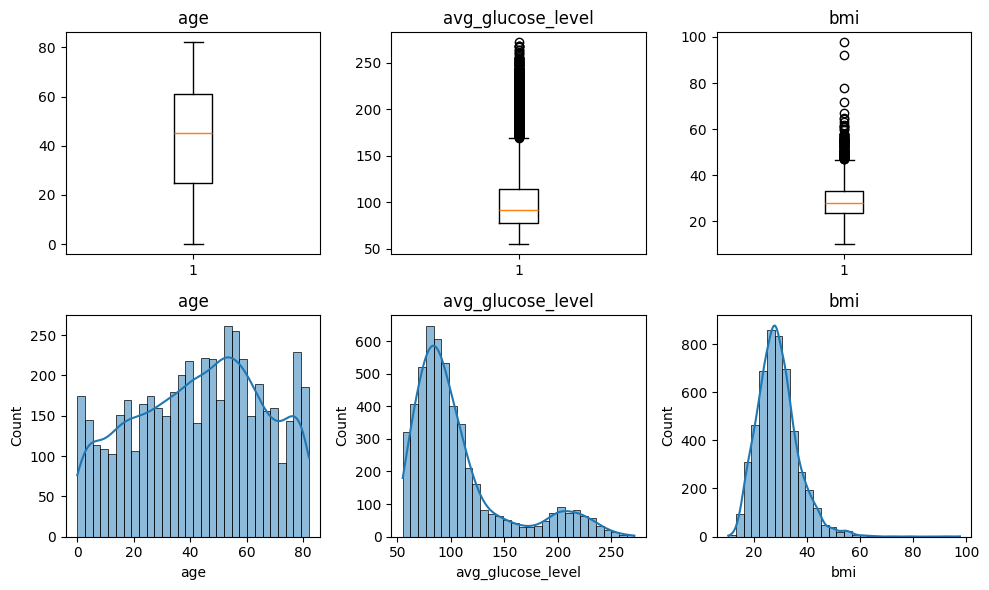

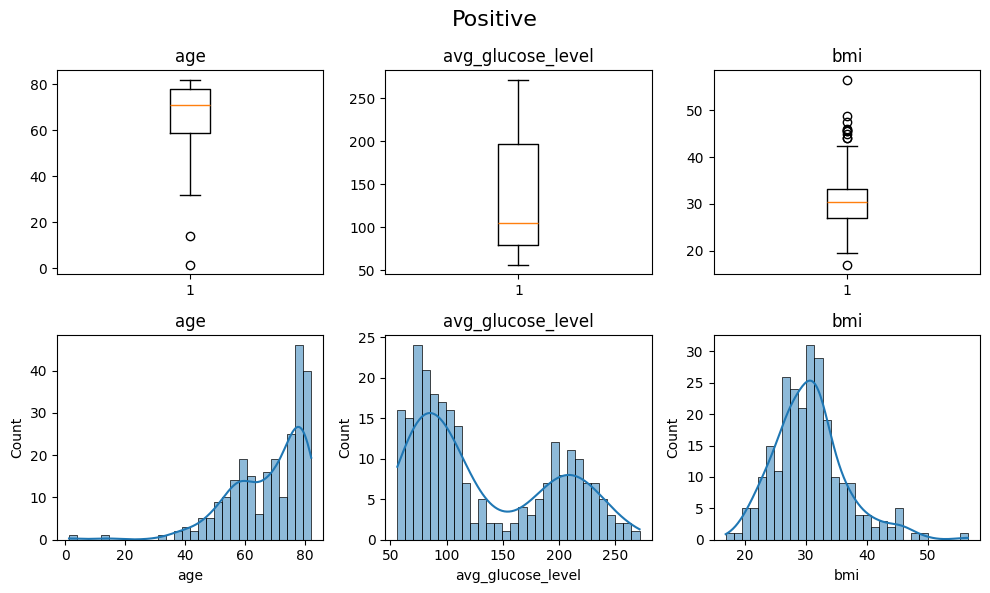

In [23]:
def num_col_Analysis(df, num_cols, n_rows, n_cols, title = None):
  plt.figure(figsize = (10, 6))

  i = 1
  for col in num_cols:
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(df[col])
    plt.title(col)
    i += 1

  for col in num_cols:
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], bins = 30, kde = True)
    plt.title(col)
    i += 1

  if title:
    plt.suptitle(title, fontsize=16)

  plt.tight_layout()
  plt.show()

num_col_Analysis(df_update, num_cols, 2, 3)
num_col_Analysis(df_pos, num_cols, 2, 3, 'Positive')

In [24]:
def analyze_outliers(df, cols = ['avg_glucose_level', 'bmi']):
  results = []

  for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outliers_percentage = (len(outliers) / len(df)) * 100

    outliers_stroke_rate = df[(df[col] < lower_bound) | (df[col] > upper_bound)]['stroke'].mean()
    normal_stroke_rate = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]['stroke'].mean()

    results.append({
        'feature': col,
        'total_outliers': len(outliers),
        'total_sample': len(df),
        'outliers_percentage': outliers_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'min_value': df[col].min(),
        'max_value': df[col].max(),
        'outliers_stroke_rate': outliers_stroke_rate,
        'normal_stroke_rate': normal_stroke_rate
    })

  return pd.DataFrame(results)

outliers_analysis = analyze_outliers(df_update)
outliers_analysis

feature  total_outliers  total_sample  outliers_percentage  \
0  avg_glucose_level             627          5110            12.270059   
1                bmi             119          5110             2.328767   

   lower_bound  upper_bound  min_value  max_value  outliers_stroke_rate  \
0      21.9775     169.3575      55.12     271.74              0.133971   
1      10.0000      46.8000      10.30      97.60              0.025210   

   normal_stroke_rate  
0            0.036806  
1            0.049289

In [25]:
def handle_outliers(df, outliers_analysis):
  df_cleaned = df.copy()

  for index, row in outliers_analysis.iterrows():
    col = row['feature']
    lower_bound = row['lower_bound']
    upper_bound = row['upper_bound']

    df_cleaned[f'{col}_outlier'] = ((df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)).astype(int)

    if col == 'avg_glucose_level':
      df_cleaned[f'{col}_category'] = pd.cut(
          df_cleaned[col],
          bins = [-float('inf'), 70, 100, 125, 200, float('inf')],
          labels = ['Hypoglycemic', 'Normal', 'Prediabetic', 'Diabetic', 'Severe Diabetic']
      )
    elif col == 'bmi':
      df_cleaned[f'{col}_category'] = pd.cut(
          df_cleaned[col],
          bins = [-float('inf'), 18.5, 25, 30, 35, float('inf')],
          labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extremely Obese']
      )

    df_cleaned[col] = df_cleaned[col].clip(
        lower = lower_bound,
        upper = upper_bound
    )

  return df_cleaned

df_cleaned = handle_outliers(df_update, outliers_analysis)
df_cleaned.head()

age  hypertension  heart_disease  avg_glucose_level        bmi  stroke  \
0  67.0             0              1           169.3575  36.600000       1   
1  61.0             0              0           169.3575  32.583436       1   
2  80.0             0              1           105.9200  32.500000       1   
3  49.0             0              0           169.3575  34.400000       1   
4  79.0             1              0           169.3575  24.000000       1   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  ...  \
0          1.0           0.0               1.0                     0.0  ...   
1          0.0           0.0               1.0                     0.0  ...   
2          1.0           0.0               1.0                     0.0  ...   
3          0.0           0.0               1.0                     0.0  ...   
4          0.0           0.0               1.0                     0.0  ...   

   work_type_children  Residence_type_Urban  smoking_status_formerly smoked  \
0                 0.0                   1.0                             1.0   
1                 0.0                   0.0                             0.0   
2                 0.0                   0.0                             0.0   
3                 0.0                   1.0                             0.0   
4                 0.0                   0.0                             0.0   

   smoking_status_never smoked  smoking_status_smokes  bmi_imputed  \
0                          0.0                    0.0            0   
1                          1.0                    0.0            1   
2                          1.0                    0.0            0   
3                          0.0                    1.0            0   
4                          1.0                    0.0            0   

   avg_glucose_level_outlier  avg_glucose_level_category  bmi_outlier  \
0                          1             Severe Diabetic            0   
1                          1             Severe Diabetic            0   
2                          0                 Prediabetic            0   
3                          1                    Diabetic            0   
4                          1                    Diabetic            0   

      bmi_category  
0  Extremely Obese  
1            Obese  
2            Obese  
3            Obese  
4           Normal  

[5 rows x 22 columns]

In [26]:
df_cleaned.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'bmi_imputed', 'avg_glucose_level_outlier',
       'avg_glucose_level_category', 'bmi_outlier', 'bmi_category'],
      dtype='object')


Validation Results for avg_glucose_level:
Original correlation with stroke: 0.1319
Cleaned correlation with stroke: 0.1157

Validation Results for bmi:
Original correlation with stroke: 0.0504
Cleaned correlation with stroke: 0.0577


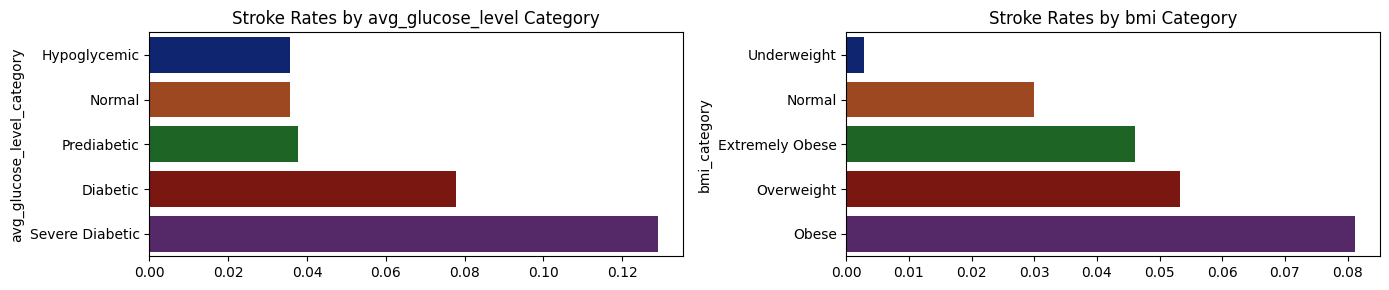

In [27]:
def validate_outlier_treatment(df_original, df_cleaned):
  plt.figure(figsize = (14, 3))
  for i, column in enumerate(['avg_glucose_level', 'bmi'], 1):
    original_correlation = df_original[column].corr(df_original['stroke'])
    cleaned_correlation = df_cleaned[column].corr(df_cleaned['stroke'])

    print(f"\nValidation Results for {column}:")
    print(f"Original correlation with stroke: {original_correlation:.4f}")
    print(f"Cleaned correlation with stroke: {cleaned_correlation:.4f}")

    if f'{column}_category' in df_cleaned:
      cat_stroke_rate = df_cleaned.groupby(f'{column}_category', observed=True)['stroke'].mean()
      cat_stroke_rate = cat_stroke_rate.sort_values()

      plt.subplot(1, 2, i)
      sns.barplot(x = cat_stroke_rate.values, y = cat_stroke_rate.index, hue = cat_stroke_rate.values, palette = 'dark', order=cat_stroke_rate.index)
      plt.title(f'Stroke Rates by {column} Category')
      plt.tight_layout()
      plt.legend().set_visible(False)

  plt.show()

validate_outlier_treatment(df_update, df_cleaned)

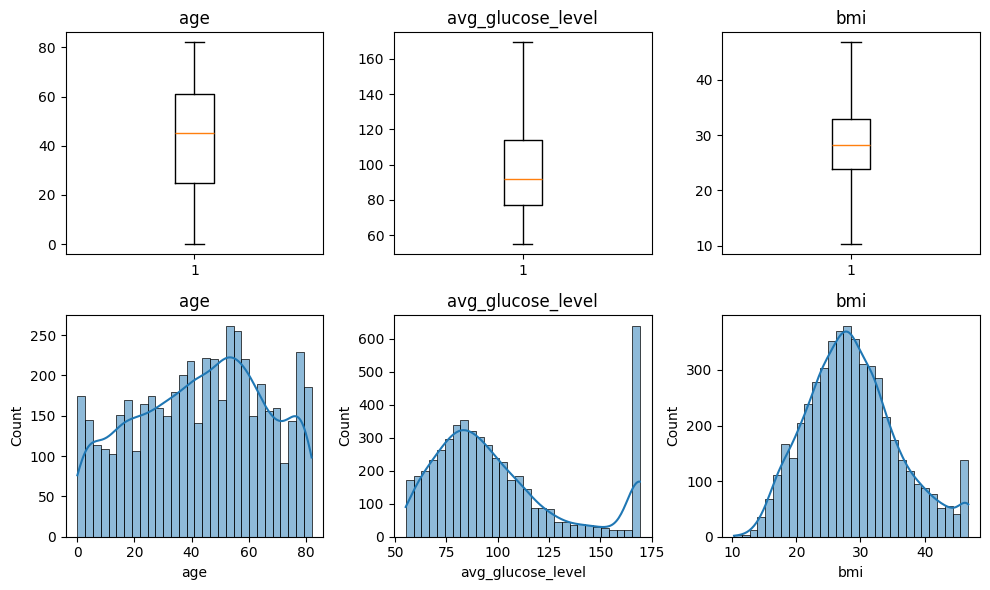

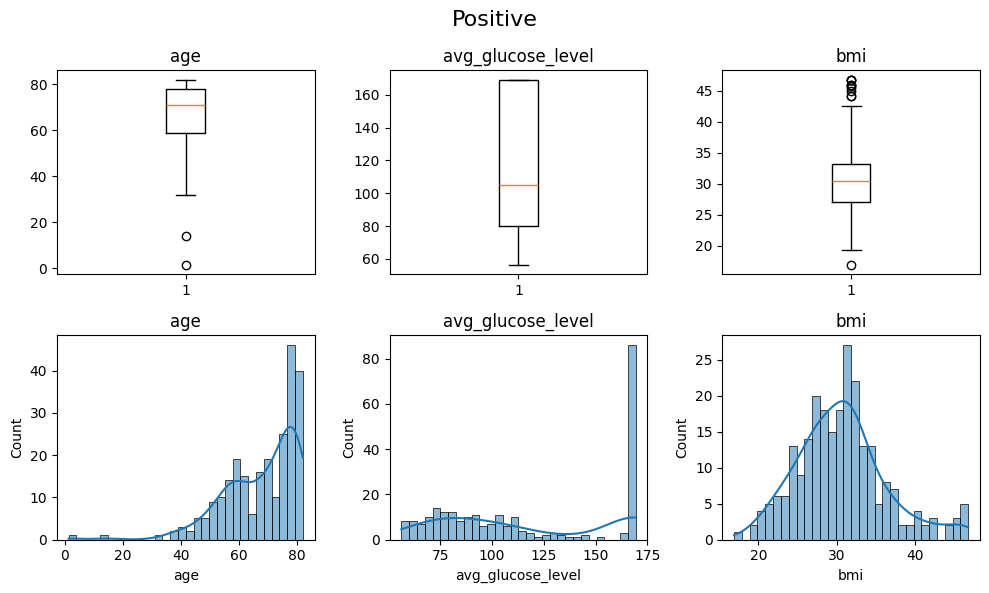

In [28]:
df_pos = df_cleaned[df_cleaned['stroke'] == 1]

num_col_Analysis(df_cleaned, num_cols, 2, 3)
num_col_Analysis(df_pos, num_cols, 2, 3, 'Positive')

In [29]:
new_cat = new_cat = [col for col in df_cleaned.select_dtypes(include=['object', 'category']).columns]

encoder = OneHotEncoder(drop = None, sparse_output = False)
df_encoded = pd.DataFrame(encoder.fit_transform(df_cleaned[new_cat]), columns = encoder.get_feature_names_out(new_cat))
df_encoded.head()

avg_glucose_level_category_Diabetic  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  1.0   
4                                  1.0   

   avg_glucose_level_category_Hypoglycemic  avg_glucose_level_category_Normal  \
0                                      0.0                                0.0   
1                                      0.0                                0.0   
2                                      0.0                                0.0   
3                                      0.0                                0.0   
4                                      0.0                                0.0   

   avg_glucose_level_category_Prediabetic  \
0                                     0.0   
1                                     0.0   
2                                     1.0   
3                                     0.0   
4                                     0.0   

   avg_glucose_level_category_Severe Diabetic  bmi_category_Extremely Obese  \
0                                         1.0                           1.0   
1                                         1.0                           0.0   
2                                         0.0                           0.0   
3                                         0.0                           0.0   
4                                         0.0                           0.0   

   bmi_category_Normal  bmi_category_Obese  bmi_category_Overweight  \
0                  0.0                 0.0                      0.0   
1                  0.0                 1.0                      0.0   
2                  0.0                 1.0                      0.0   
3                  0.0                 1.0                      0.0   
4                  1.0                 0.0                      0.0   

   bmi_category_Underweight  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0

In [30]:
df_new = pd.concat([df_cleaned.drop(new_cat + ['stroke'], axis = 1), df_encoded, df['stroke']], axis = 1)
df_new.head()

age  hypertension  heart_disease  avg_glucose_level        bmi  \
0  67.0             0              1           169.3575  36.600000   
1  61.0             0              0           169.3575  32.583436   
2  80.0             0              1           105.9200  32.500000   
3  49.0             0              0           169.3575  34.400000   
4  79.0             1              0           169.3575  24.000000   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0          1.0           0.0               1.0                     0.0   
1          0.0           0.0               1.0                     0.0   
2          1.0           0.0               1.0                     0.0   
3          0.0           0.0               1.0                     0.0   
4          0.0           0.0               1.0                     0.0   

   work_type_Private  ...  avg_glucose_level_category_Hypoglycemic  \
0                1.0  ...                                      0.0   
1                0.0  ...                                      0.0   
2                1.0  ...                                      0.0   
3                1.0  ...                                      0.0   
4                0.0  ...                                      0.0   

   avg_glucose_level_category_Normal  avg_glucose_level_category_Prediabetic  \
0                                0.0                                     0.0   
1                                0.0                                     0.0   
2                                0.0                                     1.0   
3                                0.0                                     0.0   
4                                0.0                                     0.0   

   avg_glucose_level_category_Severe Diabetic  bmi_category_Extremely Obese  \
0                                         1.0                           1.0   
1                                         1.0                           0.0   
2                                         0.0                           0.0   
3                                         0.0                           0.0   
4                                         0.0                           0.0   

   bmi_category_Normal  bmi_category_Obese  bmi_category_Overweight  \
0                  0.0                 0.0                      0.0   
1                  0.0                 1.0                      0.0   
2                  0.0                 1.0                      0.0   
3                  0.0                 1.0                      0.0   
4                  1.0                 0.0                      0.0   

   bmi_category_Underweight  stroke  
0                       0.0       1  
1                       0.0       1  
2                       0.0       1  
3                       0.0       1  
4                       0.0       1  

[5 rows x 30 columns]

In [31]:
df_pos = df[df['stroke'] == 1]
df_pos.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

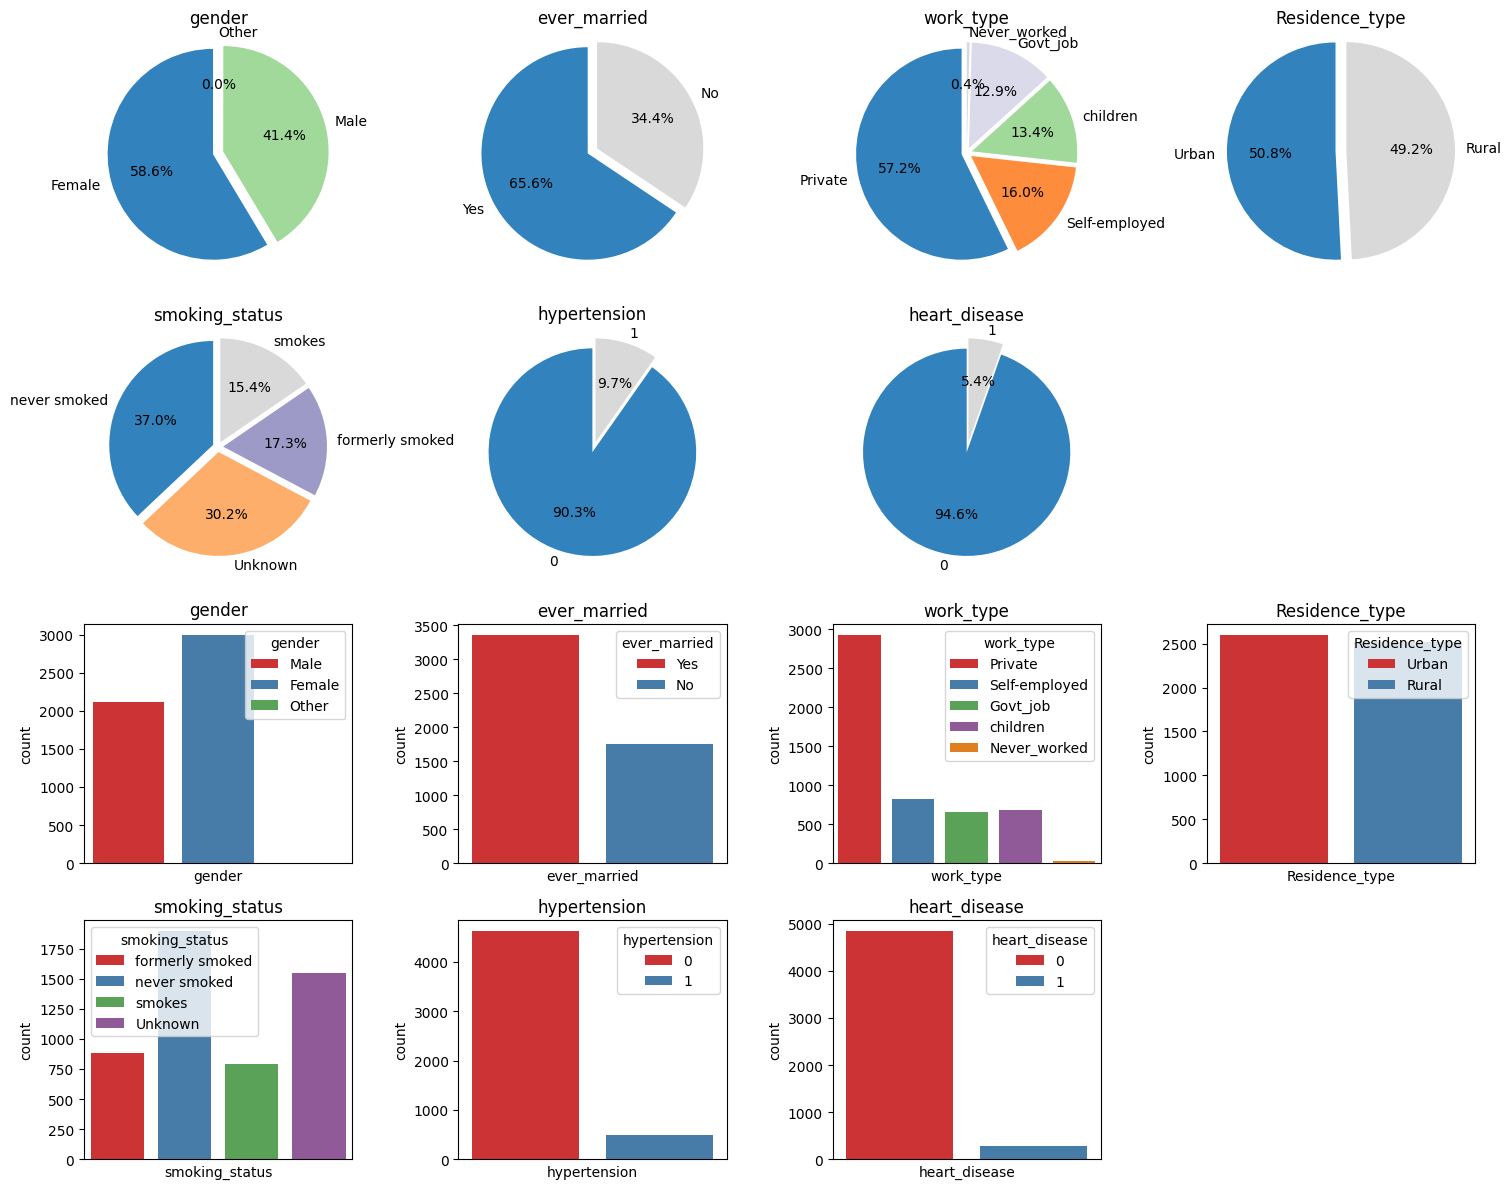

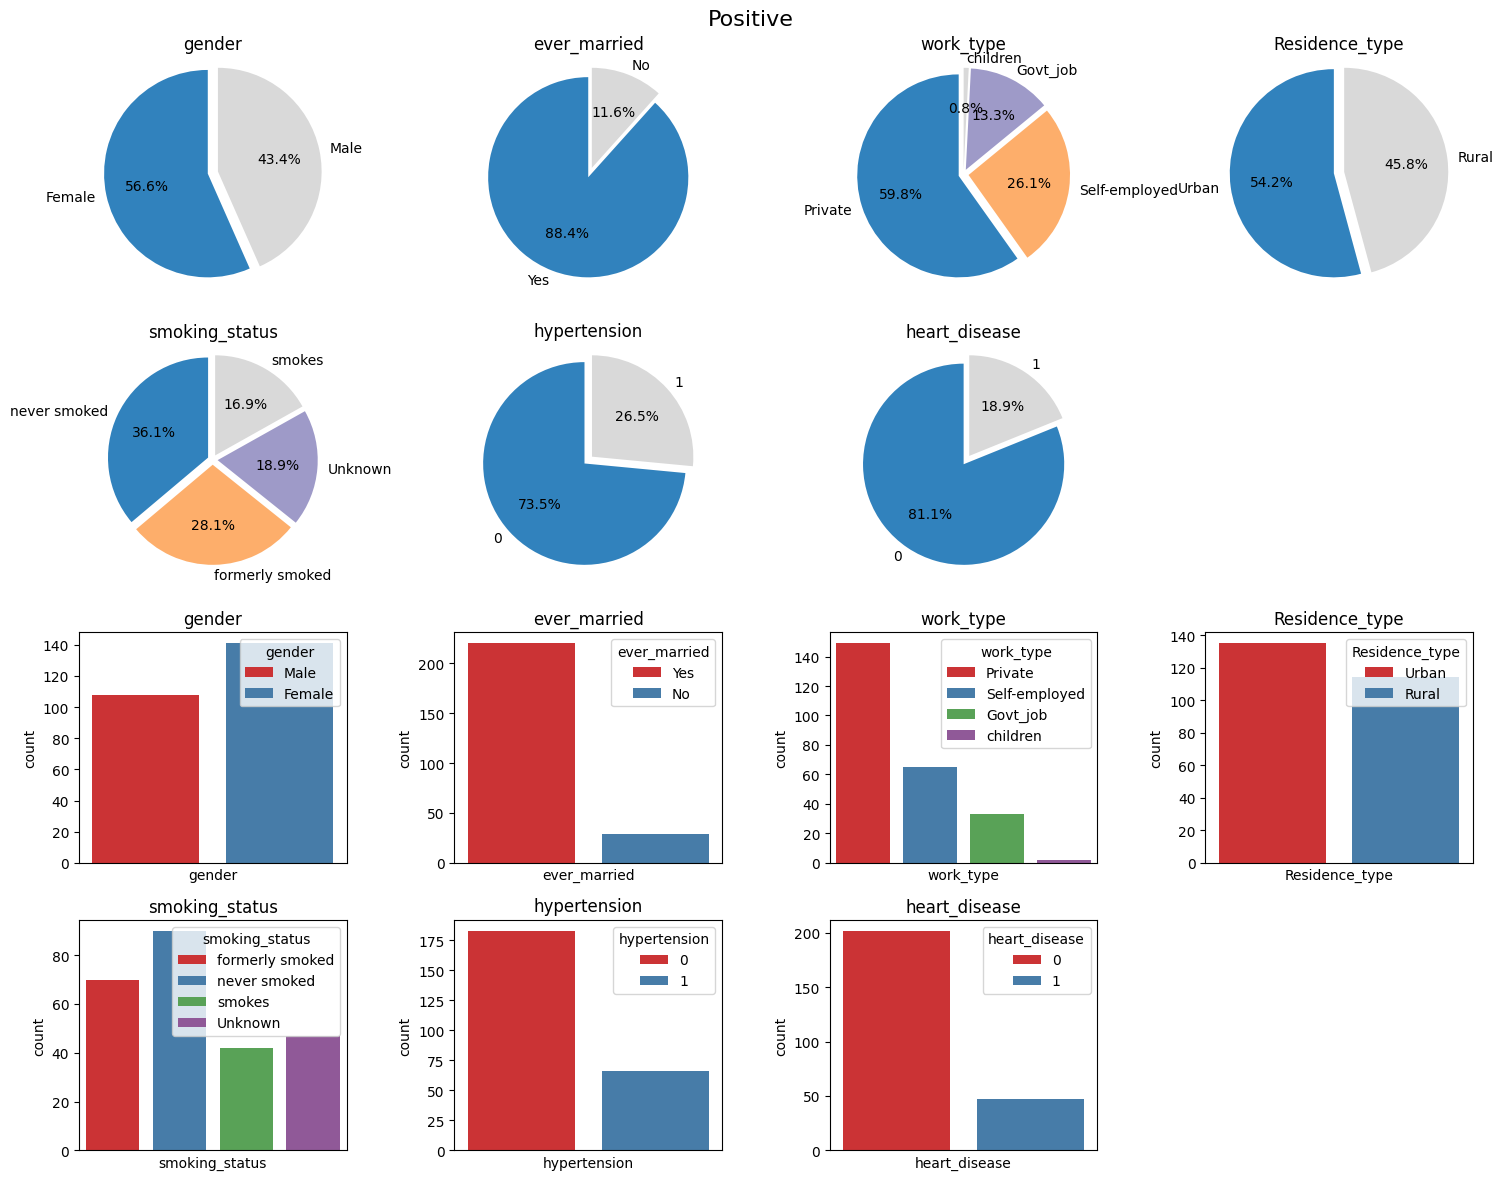

In [32]:
def non_num_col_Analysis(df, non_num_cols, n_rows, n_cols, title = None):
  plt.figure(figsize = (15, 12))
  i = 1
  for col in non_num_cols:
    cat_count = df[col].value_counts()
    explode = [0.05] * len(cat_count)
    plt.subplot(n_rows, n_cols, i)
    cat_count.plot(kind = 'pie', autopct = '%.1f%%', startangle = 90, shadow = False, cmap = 'tab20c', explode = explode)
    plt.title(col)
    plt.axis('equal')
    plt.ylabel('')
    i += 1

  i += 1
  for col in non_num_cols:
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(x = col, data = df, hue = col, palette = 'Set1', legend = True)
    plt.title(col)
    plt.xticks([])
    i += 1

  if title:
    plt.suptitle(title, fontsize=16)

  plt.tight_layout()
  plt.show()

non_num_col_Analysis(df, non_num_cols, 4, 4)
non_num_col_Analysis(df_pos, non_num_cols, 4, 4, 'Positive')

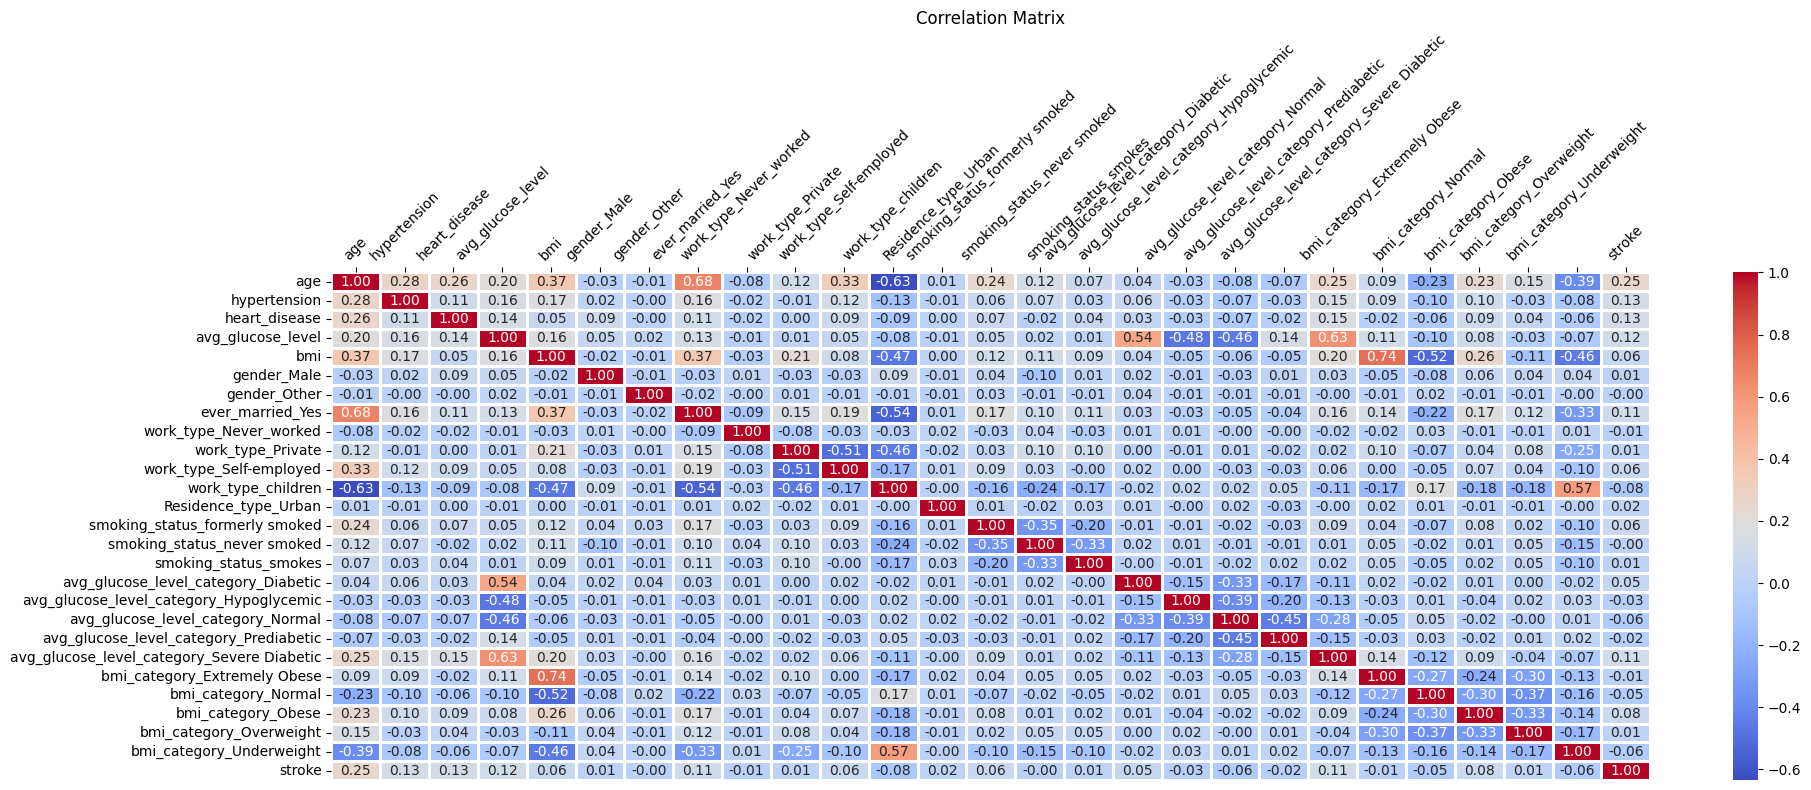

Most Co-releated Features:
age                                           0.245257
heart_disease                                 0.134914
hypertension                                  0.127904
avg_glucose_level                             0.115652
avg_glucose_level_category_Severe Diabetic    0.113633
ever_married_Yes                              0.108340
bmi_category_Obese                            0.078687
smoking_status_formerly smoked                0.064556
work_type_Self-employed                       0.062168
bmi                                           0.057650
avg_glucose_level_category_Diabetic           0.047556
Residence_type_Urban                          0.015458
bmi_category_Overweight                       0.013591
work_type_Private                             0.011888
gender_Male                                   0.009117
smoking_status_smokes                         0.008939
gender_Other                                 -0.003166
smoking_status_never smoked           

In [33]:
corr_mat = df_new.drop(['bmi_imputed', 'avg_glucose_level_outlier', 'bmi_outlier'], axis = 1).corr()

plt.figure(figsize = (20, 8))
sns.heatmap(corr_mat, annot = True, linewidths = 1, linecolor = 'white', cmap = 'coolwarm', fmt = '.2f')
plt.gca().tick_params(axis='x', rotation=45, labelsize=10)
plt.gca().tick_params(axis='y', labelsize=10)
plt.gca().xaxis.set_ticks_position('top')

plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

print("Most Co-releated Features:")
print(corr_mat['stroke'].sort_values(ascending = False).drop('stroke'))

In [34]:
def feature_analysis(df):
  mi_score = mutual_info_classif(df.drop(['stroke', 'bmi_imputed', 'avg_glucose_level_outlier', 'bmi_outlier'], axis = 1), df['stroke'])
  mi_imp = pd.DataFrame({'Feature': df.drop(['stroke', 'bmi_imputed', 'avg_glucose_level_outlier', 'bmi_outlier'], axis = 1).columns, 'Score': mi_score}).sort_values(by = 'Score', ascending = False)

  rf_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
  rf_model.fit(df.drop(['stroke', 'bmi_imputed', 'avg_glucose_level_outlier', 'bmi_outlier'], axis = 1), df['stroke'])
  rf_imp = pd.DataFrame({'Feature': df.drop(['stroke', 'bmi_imputed', 'avg_glucose_level_outlier', 'bmi_outlier'], axis = 1).columns, 'Score': rf_model.feature_importances_}).sort_values(by = 'Score', ascending = False)

  new_cat = [col for col in df.select_dtypes(include = ['int64', 'float64']).columns if df[col].std() < 1 and col not in ['stroke', 'bmi_imputed', 'avg_glucose_level_outlier', 'bmi_outlier']]

  chi2_score, pvals = chi2(df[new_cat], df['stroke'])
  chi2_imp = pd.DataFrame({'Feature': new_cat, 'Score': chi2_score, 'P-Value': pvals}).sort_values(by = 'Score', ascending = False)

  return mi_imp, rf_imp, chi2_imp

mi_imp, rf_imp, chi2_imp = feature_analysis(df_new)

In [35]:
def plot_feature_imp(imp_df, x_col, title, pos, top_n = 10):
  plt.subplot(2, 2, pos)
  sns.barplot(data = imp_df.head(top_n), x = x_col, y = 'Feature', hue = x_col, palette = 'Paired')
  plt.title(title)
  plt.legend().set_visible(False)
  plt.tight_layout()

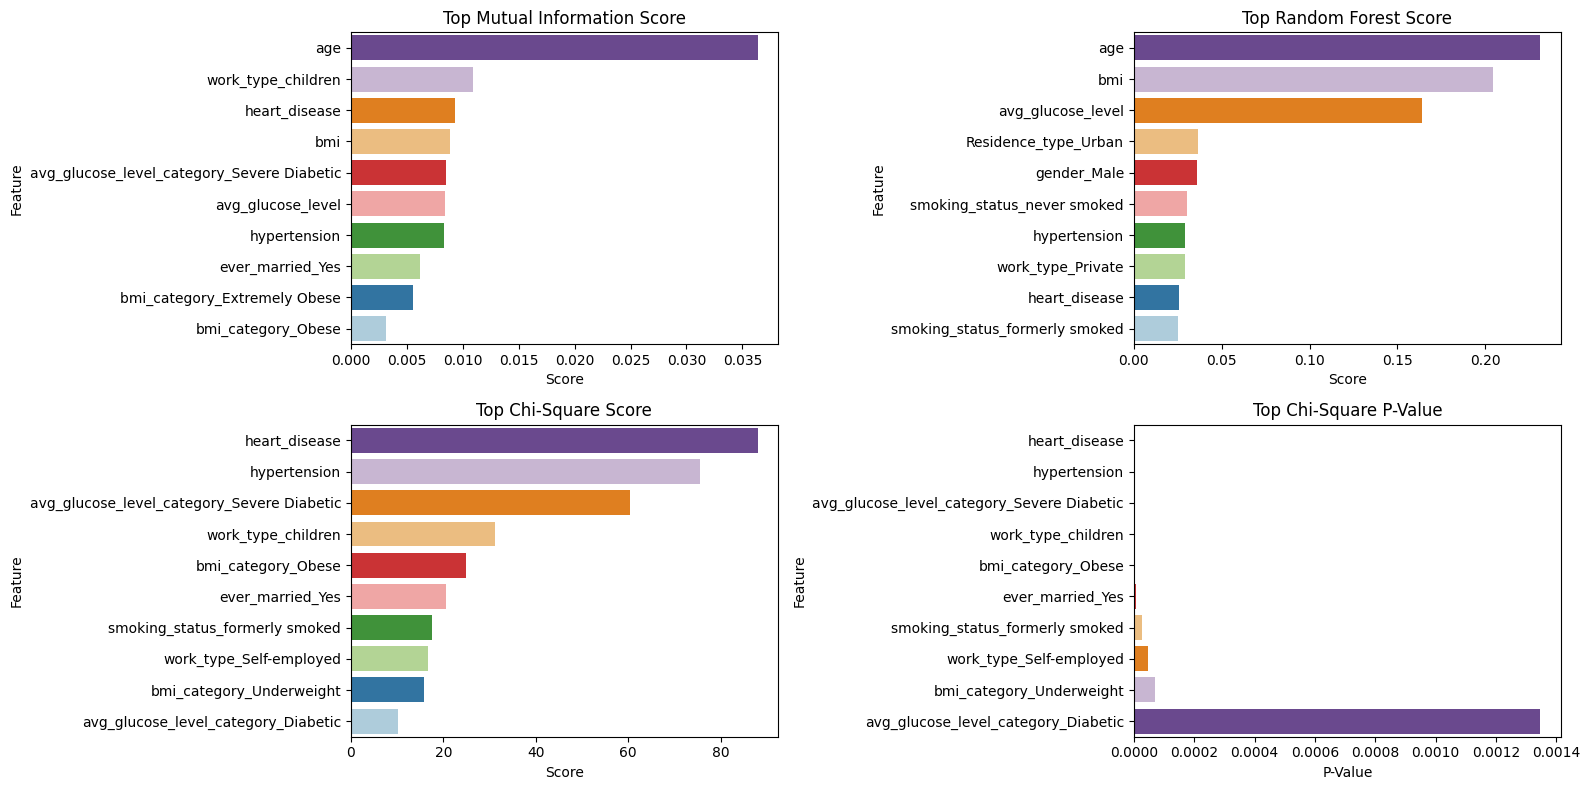

In [36]:
plt.figure(figsize = (16, 8))
plot_feature_imp(mi_imp, 'Score', 'Top Mutual Information Score', 1)
plot_feature_imp(rf_imp, 'Score', 'Top Random Forest Score', 2)
plot_feature_imp(chi2_imp, 'Score', 'Top Chi-Square Score', 3)
plot_feature_imp(chi2_imp, 'P-Value', 'Top Chi-Square P-Value', 4)
plt.show()

In [37]:
df_new.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'bmi_imputed', 'avg_glucose_level_outlier',
       'bmi_outlier', 'avg_glucose_level_category_Diabetic',
       'avg_glucose_level_category_Hypoglycemic',
       'avg_glucose_level_category_Normal',
       'avg_glucose_level_category_Prediabetic',
       'avg_glucose_level_category_Severe Diabetic',
       'bmi_category_Extremely Obese', 'bmi_category_Normal',
       'bmi_category_Obese', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'stroke'],
      dtype='object')

In [38]:
selected_features = ['age', 'bmi', 'avg_glucose_level', 'heart_disease', 'hypertension', 'ever_married_Yes', 'work_type_Private', 'work_type_Self-employed', 'work_type_children',
                     'smoking_status_formerly smoked', 'smoking_status_never smoked', 'gender_Male', 'bmi_imputed', 'avg_glucose_level_outlier', 'bmi_outlier', 'avg_glucose_level_category_Diabetic',
                     'avg_glucose_level_category_Severe Diabetic', 'bmi_category_Obese', 'bmi_category_Overweight', 'bmi_category_Underweight']

len(selected_features)

20

In [39]:
df_new.head()

age  hypertension  heart_disease  avg_glucose_level        bmi  \
0  67.0             0              1           169.3575  36.600000   
1  61.0             0              0           169.3575  32.583436   
2  80.0             0              1           105.9200  32.500000   
3  49.0             0              0           169.3575  34.400000   
4  79.0             1              0           169.3575  24.000000   

   gender_Male  gender_Other  ever_married_Yes  work_type_Never_worked  \
0          1.0           0.0               1.0                     0.0   
1          0.0           0.0               1.0                     0.0   
2          1.0           0.0               1.0                     0.0   
3          0.0           0.0               1.0                     0.0   
4          0.0           0.0               1.0                     0.0   

   work_type_Private  ...  avg_glucose_level_category_Hypoglycemic  \
0                1.0  ...                                      0.0   
1                0.0  ...                                      0.0   
2                1.0  ...                                      0.0   
3                1.0  ...                                      0.0   
4                0.0  ...                                      0.0   

   avg_glucose_level_category_Normal  avg_glucose_level_category_Prediabetic  \
0                                0.0                                     0.0   
1                                0.0                                     0.0   
2                                0.0                                     1.0   
3                                0.0                                     0.0   
4                                0.0                                     0.0   

   avg_glucose_level_category_Severe Diabetic  bmi_category_Extremely Obese  \
0                                         1.0                           1.0   
1                                         1.0                           0.0   
2                                         0.0                           0.0   
3                                         0.0                           0.0   
4                                         0.0                           0.0   

   bmi_category_Normal  bmi_category_Obese  bmi_category_Overweight  \
0                  0.0                 0.0                      0.0   
1                  0.0                 1.0                      0.0   
2                  0.0                 1.0                      0.0   
3                  0.0                 1.0                      0.0   
4                  1.0                 0.0                      0.0   

   bmi_category_Underweight  stroke  
0                       0.0       1  
1                       0.0       1  
2                       0.0       1  
3                       0.0       1  
4                       0.0       1  

[5 rows x 30 columns]

In [40]:
X = df_new[selected_features]
X.shape

(5110, 20)

In [41]:
new_cat = [col for col in selected_features if df_new[col].std() < 1]
num_cols

['age', 'avg_glucose_level', 'bmi']

In [42]:
Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X[num_cols])
X_scaled = pd.DataFrame(X_scaled, columns = num_cols)
X_scaled = pd.concat([X_scaled, X[new_cat]], axis = 1)
X_scaled.head()

age  avg_glucose_level       bmi  heart_disease  hypertension  \
0  1.051434           2.058363  1.088413              1             0   
1  0.786070           2.058363  0.528851              0             0   
2  1.626390           0.148256  0.517227              1             0   
3  0.255342           2.058363  0.781923              0             0   
4  1.582163           2.058363 -0.666939              0             1   

   ever_married_Yes  work_type_Private  work_type_Self-employed  \
0               1.0                1.0                      0.0   
1               1.0                0.0                      1.0   
2               1.0                1.0                      0.0   
3               1.0                1.0                      0.0   
4               1.0                0.0                      1.0   

   work_type_children  smoking_status_formerly smoked  \
0                 0.0                             1.0   
1                 0.0                             0.0   
2                 0.0                             0.0   
3                 0.0                             0.0   
4                 0.0                             0.0   

   smoking_status_never smoked  gender_Male  bmi_imputed  \
0                          0.0          1.0            0   
1                          1.0          0.0            1   
2                          1.0          1.0            0   
3                          0.0          0.0            0   
4                          1.0          0.0            0   

   avg_glucose_level_outlier  bmi_outlier  \
0                          1            0   
1                          1            0   
2                          0            0   
3                          1            0   
4                          1            0   

   avg_glucose_level_category_Diabetic  \
0                                  0.0   
1                                  0.0   
2                                  0.0   
3                                  1.0   
4                                  1.0   

   avg_glucose_level_category_Severe Diabetic  bmi_category_Obese  \
0                                         1.0                 0.0   
1                                         1.0                 1.0   
2                                         0.0                 1.0   
3                                         0.0                 1.0   
4                                         0.0                 0.0   

   bmi_category_Overweight  bmi_category_Underweight  
0                      0.0                       0.0  
1                      0.0                       0.0  
2                      0.0                       0.0  
3                      0.0                       0.0  
4                      0.0                       0.0

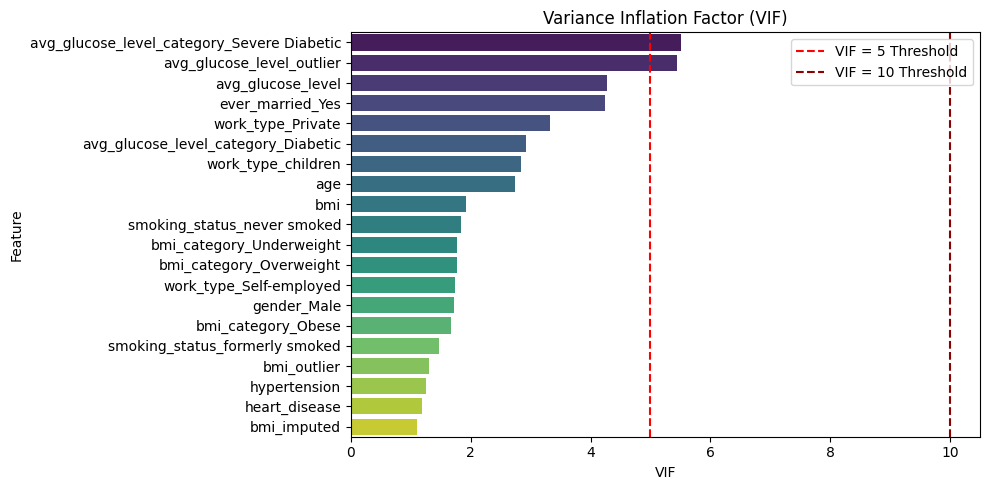


VIF Analysis Results:
Features with high multicollinearity (VIF > 10):
[]
Features with moderate multicollinearity (5 < VIF < 10):
['avg_glucose_level_category_Severe Diabetic', 'avg_glucose_level_outlier']


In [43]:
def analyze_vif(X_scaled, plot = True):
  vif_data = pd.DataFrame()
  vif_data['Feature'] = X_scaled.columns
  vif_data['VIF'] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

  vif_data = vif_data.sort_values(by = 'VIF', ascending = False)

  if plot:
    plt.figure(figsize = (10, 5))
    sns.barplot(data = vif_data, x = 'VIF', y = 'Feature', hue = 'Feature', palette = 'viridis')
    plt.title('Variance Inflation Factor (VIF)')
    plt.axvline(x = 5, color = 'red', linestyle = '--', label = 'VIF = 5 Threshold')
    plt.axvline(x = 10, color = 'darkred', linestyle = '--', label = 'VIF = 10 Threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nVIF Analysis Results:")
    print("Features with high multicollinearity (VIF > 10):")
    print(vif_data[vif_data['VIF'] > 10]['Feature'].tolist())
    print("Features with moderate multicollinearity (5 < VIF < 10):")
    print(vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]['Feature'].tolist())

  return vif_data

vif_result = analyze_vif(X_scaled)

In [44]:
rus = RandomUnderSampler(random_state = 42)
X_rus, y_rus = rus.fit_resample(X, df['stroke'])

smote = SMOTE(random_state = 42)
X_smote, y_smote = smote.fit_resample(X, df['stroke'])

smt = SMOTETomek(random_state = 42)
X_smt, y_smt = smt.fit_resample(X, df['stroke'])

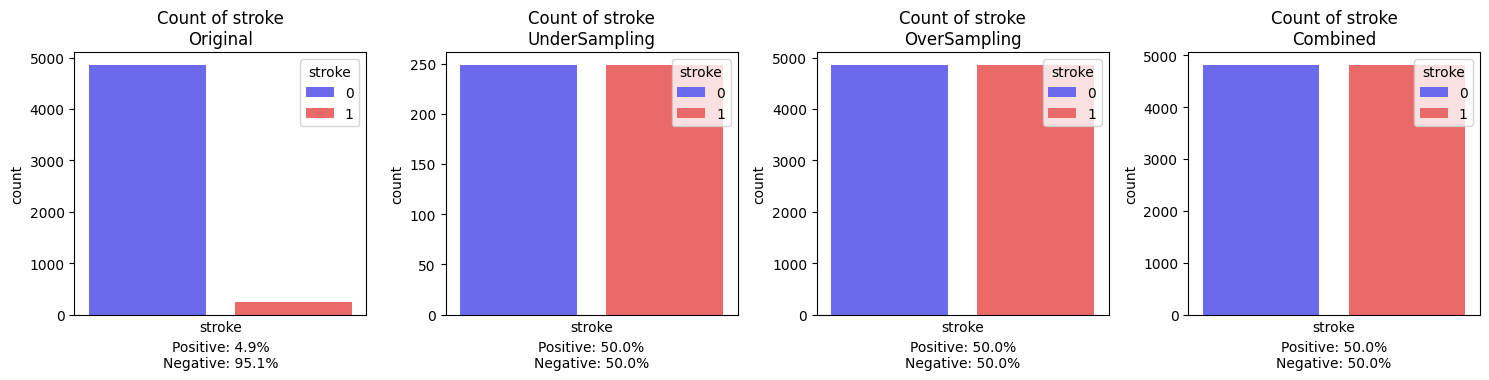

In [45]:
plot_target_distributions({
    'Original': (df, 'stroke'),
    'UnderSampling': (pd.DataFrame({'stroke': y_rus}), 'stroke'),
    'OverSampling': (pd.DataFrame({'stroke': y_smote}), 'stroke'),
    'Combined': (pd.DataFrame({'stroke': y_smt}), 'stroke')
})

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_smt, y_smt, test_size = 0.2, random_state = 42, stratify = y_smt)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7708, 20)
y_train shape: (7708,)
X_test shape: (1928, 20)
y_test shape: (1928,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42, stratify = y_smote)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (7777, 20)
y_train shape: (7777,)
X_test shape: (1945, 20)
y_test shape: (1945,)


In [47]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[num_cols] = Scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = Scaler.transform(X_test[num_cols])

In [48]:
X_test_scaled.shape

(1928, 20)

In [49]:
def build_model(params, input_dim):
  model = Sequential([
      Dense(params['neurons_1'], kernel_regularizer = regularizers.l2(params['l2_reg']), input_dim = input_dim),
      LeakyReLU(alpha = params['alpha']),
      BatchNormalization(),
      Dropout(params['dropout_1']),

      Dense(params['neurons_2'], kernel_regularizer = regularizers.l2(params['l2_reg'])),
      LeakyReLU(alpha = params['alpha']),
      BatchNormalization(),
      Dropout(params['dropout_2']),

      Dense(params['neurons_3'], kernel_regularizer = regularizers.l2(params['l2_reg'])),
      LeakyReLU(alpha = params['alpha']),
      BatchNormalization(),
      Dropout(params['dropout_3']),

      Dense(1, activation = 'sigmoid')
  ])

  model.compile(optimizer = Adam(learning_rate = params['learning_rate']), loss = 'binary_crossentropy', metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')])
  return model

In [50]:
def objective(trail):
  params = {
      'neurons_1' : trail.suggest_int('neurons_1', 64, 256, 32),
      'neurons_2' : trail.suggest_int('neurons_2', 32, 128, 16),
      'neurons_3' : trail.suggest_int('neurons_3', 16, 64, 8),
      'dropout_1' : trail.suggest_float('dropout_1', 0.2, 0.5, step = 0.1),
      'dropout_2' : trail.suggest_float('dropout_2', 0.2, 0.5, step = 0.1),
      'dropout_3' : trail.suggest_float('dropout_3', 0.1, 0.4, step = 0.1),
      'l2_reg' : trail.suggest_float('l2_reg', 1e-4, 1e-2, log = True),
      'learning_rate' : trail.suggest_float('learning_rate', 1e-4, 1e-2, log = True),
      'alpha' : trail.suggest_float('alpha', 0.01, 0.3, log = True)
  }

  model = build_model(params, X_train_scaled.shape[1])

  history = model.fit(X_train_scaled, y_train,
                      epochs = 50, batch_size = 32, validation_split = 0.2,
                      callbacks = [EarlyStopping(monitor = 'val_auc', patience = 10, restore_best_weights = True, mode = 'max')],
                      # class_weight = {0 : 1, 1 : 5},
                      verbose = 0)

  return max(history.history.get('val_auc', history.history.get('val_AUC', [0])))

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 30)

print("Best Neural Network Parameters:")
best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value}")

[I 2025-03-04 02:44:33,736] A new study created in memory with name: no-name-30a5e88e-7103-4505-b715-5d5629814f09
[I 2025-03-04 02:45:07,810] Trial 0 finished with value: 0.9833754897117615 and parameters: {'neurons_1': 224, 'neurons_2': 128, 'neurons_3': 40, 'dropout_1': 0.4, 'dropout_2': 0.4, 'dropout_3': 0.1, 'l2_reg': 0.0063323737445767836, 'learning_rate': 0.0004970865955226026, 'alpha': 0.026957016351517312}. Best is trial 0 with value: 0.9833754897117615.
[I 2025-03-04 02:45:36,563] Trial 1 finished with value: 0.9744833707809448 and parameters: {'neurons_1': 160, 'neurons_2': 32, 'neurons_3': 64, 'dropout_1': 0.5, 'dropout_2': 0.2, 'dropout_3': 0.1, 'l2_reg': 0.0012114224956730583, 'learning_rate': 0.0015588819936406815, 'alpha': 0.01755997099580533}. Best is trial 0 with value: 0.9833754897117615.
[I 2025-03-04 02:45:55,056] Trial 2 finished with value: 0.8766294717788696 and parameters: {'neurons_1': 192, 'neurons_2': 96, 'neurons_3': 16, 'dropout_1': 0.30000000000000004, 'dr

Best Neural Network Parameters:
neurons_1: 192
neurons_2: 80
neurons_3: 32
dropout_1: 0.2
dropout_2: 0.4
dropout_3: 0.1
l2_reg: 0.0004897324907496324
learning_rate: 0.00038609947976547034
alpha: 0.013759094033565164


In [51]:
with open('best_params_nn.pkl', 'rb') as f:
    best_params = pickle.load(f)

print("Loaded Best Parameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Loaded Best Parameters:
neurons_1: 224
neurons_2: 48
neurons_3: 56
dropout_1: 0.30000000000000004
dropout_2: 0.5
dropout_3: 0.1
l2_reg: 0.00024054280795947556
learning_rate: 0.0005913125190219269
alpha: 0.010115588274864739


In [52]:
def get_callbacks(patience = 15):
  return [
      EarlyStopping(monitor = 'val_AUC', patience = patience, restore_best_weights = True, mode = 'max'),
      ReduceLROnPlateau(monitor = 'val_AUC', factor = 0.5, patience = 5, min_lr = 0.00001, mode = 'max'),
      ModelCheckpoint('best_stroke_model.h5', monitor = 'val_AUC', save_best_only = True, mode = 'max')
  ]

In [ ]:
print("\nTraining final neural network model...")
nn_model = build_model(best_params, X_train_scaled.shape[1])
nn_model.summary()


Training final neural network model...


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_128 (Dense)                    │ (None, 224)                 │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_96 (LeakyReLU)           │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 224)                 │             896 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 48)                  │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_97 (LeakyReLU)           │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 48)                  │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_97 (Dropout)                 │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 56)                  │           2,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_98 (LeakyReLU)           │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_98               │ (None, 56)                  │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_98 (Dropout)                 │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 1)                   │              57 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,617 (76.63 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 656 (2.56 KB)

In [53]:
nn_model = load_model('optimized_model_nn.keras')

In [ ]:
history = nn_model.fit(X_train_scaled, y_train, epochs = 150, batch_size = 128,
                       validation_split = 0.2, callbacks = get_callbacks(),
                      #  class_weight={0: 1, 1: 5},
                       verbose = 1)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6781 - auc: 0.7376 - loss: 0.6764 - precision_32: 0.6671 - recall_32: 0.7051 - val_accuracy: 0.7969 - val_auc: 0.8656 - val_loss: 0.6485 - val_precision_32: 0.7665 - val_recall_32: 0.8700 - learning_rate: 5.9131e-04
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7571 - auc: 0.8353 - loss: 0.5416 - precision_32: 0.7403 - recall_32: 0.7970 - val_accuracy: 0.7963 - val_auc: 0.8783 - val_loss: 0.6089 - val_precision_32: 0.7384 - val_recall_32: 0.9350 - learning_rate: 5.9131e-04
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7818 - auc: 0.8584 - loss: 0.5080 - precision_32: 0.7651 - recall_32: 0.8130 - val_accuracy: 0.7963 - val_auc: 0.8902 - val_loss: 0.5688 - val_precision_32: 0.7302 - val_recall_32: 0.9575 - learning_rate: 5.9131e-04
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7974 - auc: 0.8754 - loss: 0.4753 - precision_32: 0.7753 - recall_32: 0.8368 - val_accuracy

In [ ]:
history = history.history

In [54]:
history = pd.read_csv('nn_training_history.csv')
history = history.to_dict(orient='list')
history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

In [ ]:
history.keys()

dict_keys(['accuracy', 'auc', 'loss', 'precision_30', 'recall_30', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision_30', 'val_recall_30', 'learning_rate'])

In [ ]:
history['history']['auc']

[0.768395185470581,
 0.8422204852104187,
 0.8631702065467834,
 0.8650635480880737,
 0.8795417547225952,
 0.8833919763565063,
 0.8921968936920166,
 0.899004340171814,
 0.896938681602478,
 0.910030484199524,
 0.9140405654907228,
 0.9155025482177734,
 0.921655774116516,
 0.9223716855049132,
 0.9282287359237672,
 0.9333741068840028,
 0.9380555748939514,
 0.9371650815010072,
 0.9397194981575012,
 0.9441077709197998,
 0.9475325345993042,
 0.9455983638763428,
 0.9512836933135986,
 0.952508270740509,
 0.954120635986328,
 0.9533002376556396,
 0.9570607542991638,
 0.9592575430870056,
 0.9567772150039672,
 0.9598281383514404,
 0.9617229104042052,
 0.9624171853065492,
 0.9615949392318726,
 0.9619975686073304,
 0.9625478982925416,
 0.9662324786186218,
 0.9660747051239014,
 0.9701995253562928,
 0.9705415964126588,
 0.9684618711471558,
 0.9700656533241272,
 0.967584788799286,
 0.96976500749588,
 0.9705919027328492,
 0.9721671342849731,
 0.9730821847915648,
 0.9738757014274596,
 0.9720700979232788,
 0

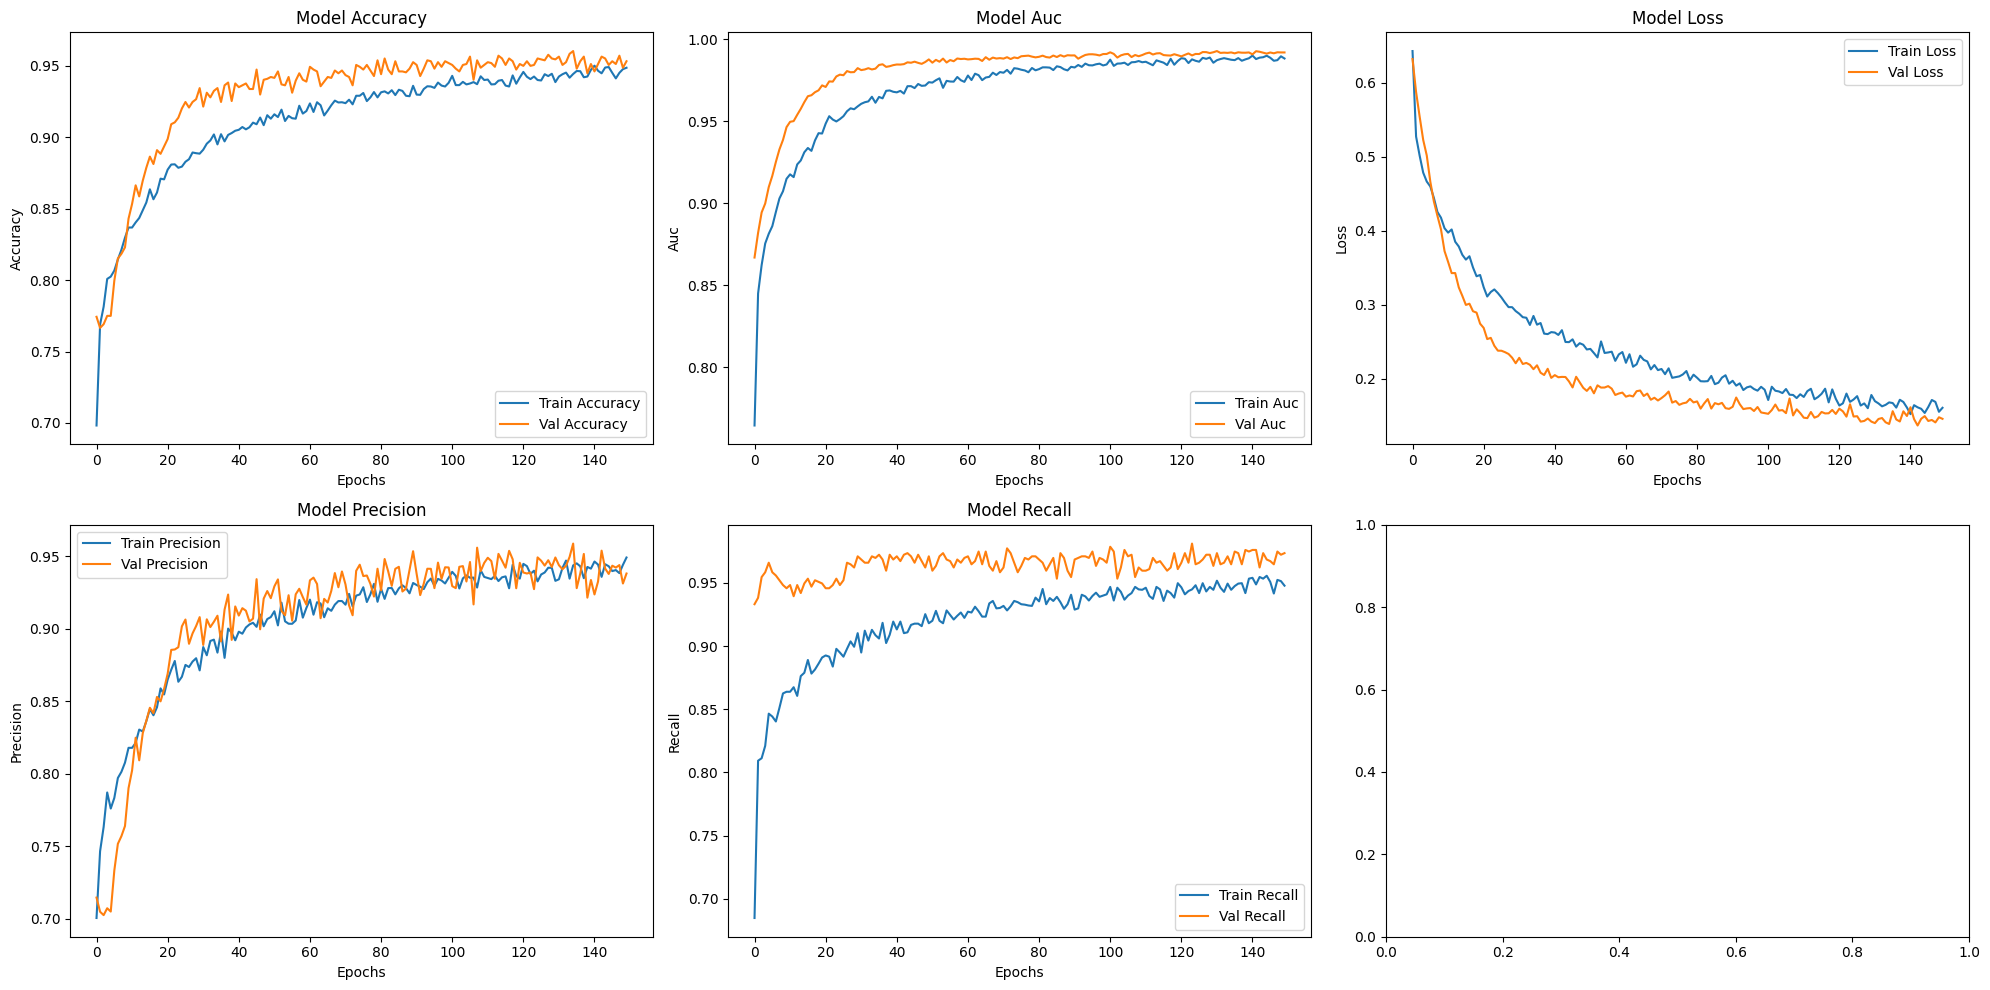

In [55]:
def plot_training_history(history):
  metrics = ['accuracy', 'auc', 'loss', 'precision', 'recall']
  fig, axes = plt.subplots(2, 3, figsize = (20, 10))

  axes = axes.flatten()
  for i, metric in enumerate(metrics):
    if metric in history:
      axes[i].plot(history[metric], label = f'Train {metric.capitalize()}')
      axes[i].plot(history[f'val_{metric}'], label = f'Val {metric.capitalize()}')
      axes[i].set_title(f'Model {metric.capitalize()}')
      axes[i].set_xlabel('Epochs')
      axes[i].set_ylabel(metric.capitalize())
      axes[i].legend()

  plt.tight_layout()
  plt.show()

plot_training_history(history)

In [ ]:
best_params

{'neurons_1': 224,
 'neurons_2': 48,
 'neurons_3': 56,
 'dropout_1': 0.30000000000000004,
 'dropout_2': 0.5,
 'dropout_3': 0.1,
 'l2_reg': 0.00024054280795947556,
 'learning_rate': 0.0005913125190219269,
 'alpha': 0.010115588274864739}

In [56]:
def find_optimal_threshold(y_pred_prob, y_test):
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  j_scores = tpr - fpr
  best_j_idx = np.argmax(j_scores)
  optimal_threshold_roc = thresholds[best_j_idx]

  precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
  f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
  best_f1_idx = np.argmax(f1_scores)
  optimal_threshold_f1 = thresholds_pr[best_f1_idx]

  print(f"Optimal threshold (ROC Youden's J): {optimal_threshold_roc:.4f}")
  print(f"Optimal threshold (F1-score): {optimal_threshold_f1:.4f}")

  return optimal_threshold_roc, optimal_threshold_f1

y_pred_prob = nn_model.predict(X_test_scaled)
optimal_threshold_roc, optimal_threshold_f1 = find_optimal_threshold(y_pred_prob, y_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Optimal threshold (ROC Youden's J): 0.5950
Optimal threshold (F1-score): 0.5950


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       964
           1       0.94      0.96      0.95       964

    accuracy                           0.95      1928
   macro avg       0.95      0.95      0.95      1928
weighted avg       0.95      0.95      0.95      1928



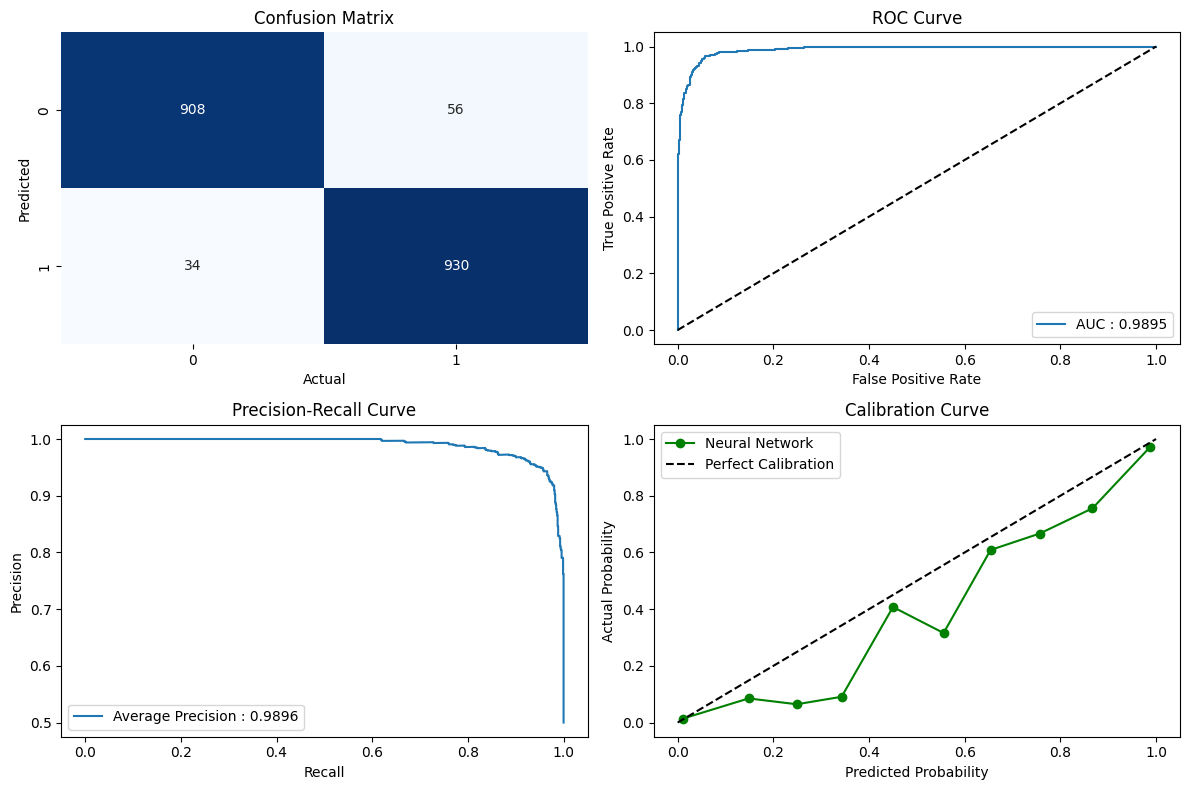

In [116]:
def plot_evaluation_matrics(y_test, y_pred_prob, optimal_threshold, model_name = 'Model', non_calib_prob = None):
  y_pred = (y_pred_prob > optimal_threshold).astype(int)

  print(classification_report(y_test, y_pred))

  fig, axes = plt.subplots(2, 2, figsize = (12, 8))

  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', cbar = False, ax = axes[0, 0])
  axes[0, 0].set_xlabel('Actual')
  axes[0, 0].set_ylabel('Predicted')
  axes[0, 0].set_title('Confusion Matrix')

  fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
  auc_score = roc_auc_score(y_test, y_pred_prob)

  axes[0, 1].plot(fpr, tpr, label = f'AUC : {auc_score:.4f}')
  axes[0, 1].plot([0, 1], [0, 1], 'k--')
  axes[0, 1].set_xlabel('False Positive Rate')
  axes[0, 1].set_ylabel('True Positive Rate')
  axes[0, 1].set_title('ROC Curve')
  axes[0, 1].legend()

  precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
  avg_precision = average_precision_score(y_test, y_pred_prob)

  axes[1, 0].plot(recall, precision, label = f'Average Precision : {avg_precision:.4f}')
  axes[1, 0].set_xlabel('Recall')
  axes[1, 0].set_ylabel('Precision')
  axes[1, 0].set_title('Precision-Recall Curve')
  axes[1, 0].legend()

  if non_calib_prob is not None:
    prob_true_cal, prob_pred_cal = calibration_curve(y_test, non_calib_prob, n_bins = 10)
    axes[1, 1].plot(prob_pred_cal, prob_true_cal, marker = 'o', label = 'Not Calibrated', color = 'gray')

  prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins = 10)
  axes[1, 1].plot(prob_pred, prob_true, marker = 'o', label = model_name, color = 'green')
  axes[1, 1].plot([0, 1], [0, 1], 'k--', label = 'Perfect Calibration')
  axes[1, 1].set_xlabel('Predicted Probability')
  axes[1, 1].set_ylabel('Actual Probability')
  axes[1, 1].set_title('Calibration Curve')
  axes[1, 1].legend()

  plt.tight_layout()
  plt.show()

  return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_prob),
        'avg_precision': average_precision_score(y_test, y_pred_prob)
    }

evaluation_metrics = plot_evaluation_matrics(y_test, nn_model.predict(X_test_scaled), optimal_threshold_roc, 'Neural Network')

In [111]:
X_train_cal, X_calib, y_train_cal, y_calib = train_test_split(X_train_scaled, y_train, test_size = 0.2, random_state = 42, stratify = y_train)

y_pred_prob_cal = nn_model.predict(X_calib).flatten()

calibrator = IsotonicRegression(out_of_bounds = 'clip')
calibrator.fit(y_pred_prob_cal, y_calib)

y_pred_prob_test = nn_model.predict(X_test_scaled).flatten()
calibrated_probs_test = calibrator.predict(y_pred_prob_test)

brier_before = brier_score_loss(y_test, y_pred_prob_test)
brier_after = brier_score_loss(y_test, calibrated_probs_test)

print(f"Brier Score Before Scaling: {brier_before:.4f}")
print(f"Brier Score After Scaling: {brier_after:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Brier Score Before Scaling: 0.0400
Brier Score After Scaling: 0.0397


Optimal threshold (ROC Youden's J): 0.3509
Optimal threshold (F1-score): 0.3509
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       964
           1       0.93      0.97      0.95       964

    accuracy                           0.95      1928
   macro avg       0.95      0.95      0.95      1928
weighted avg       0.95      0.95      0.95      1928



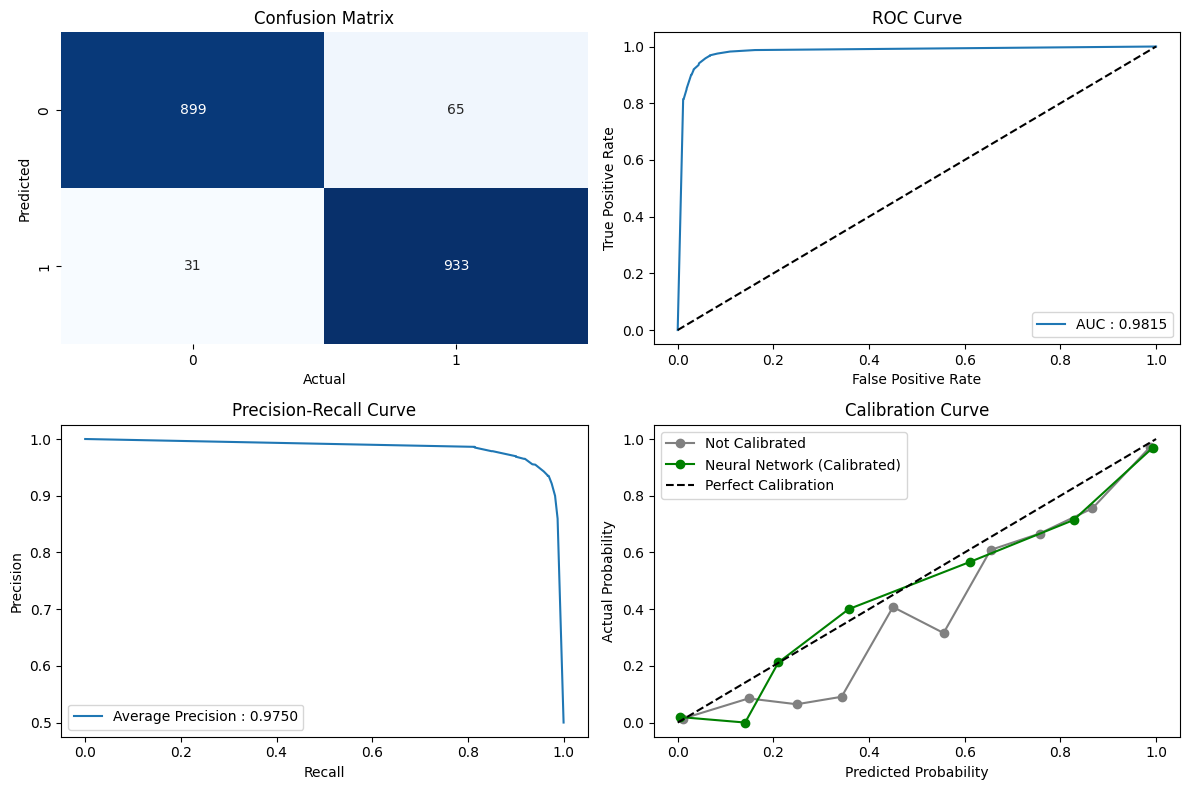

In [118]:
optimal_threshold_roc_calibrated, optimal_threshold_f1_calibrated = find_optimal_threshold(calibrated_probs_test, y_test)
evaluation_metrics_calibrated = plot_evaluation_matrics(y_test, calibrated_probs_test, optimal_threshold_roc_calibrated, "Neural Network (Calibrated)", y_pred_prob_test)

In [60]:
def expected_calibration_error(y_true, y_pred_prob, n_bins=10):
  bin_edges = np.linspace(0, 1, n_bins + 1)
  bin_indices = np.digitize(y_pred_prob, bin_edges, right=True)
  ece = 0
  for i in range(1, n_bins + 1):
    mask = bin_indices == i
    if mask.sum() > 0:
      bin_accuracy = y_true[mask].mean()
      bin_confidence = y_pred_prob[mask].mean()
      ece += mask.sum() / len(y_true) * abs(bin_accuracy - bin_confidence)
  return ece

ece_before = expected_calibration_error(y_test, y_pred_prob_test)
ece_after = expected_calibration_error(y_test, calibrated_probs_test)
print(f"ECE Before Scaling: {ece_before:.4f}")
print(f"ECE After Scaling: {ece_after:.4f}")

ECE Before Scaling: 0.0235
ECE After Scaling: 0.0165


In [61]:
np.random.seed(42)
sample_indx = np.random.choice(X_test_scaled.index, size = 100, replace = False)
X_test_sample = X_test_scaled.loc[sample_indx]

In [ ]:
def predict_fn(X):
  raw_prob = nn_model.predict(X).flatten()
  return calibrator.predict(raw_prob)

explainer = shap.KernelExplainer(predict_fn, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
6525/6525 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [62]:
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

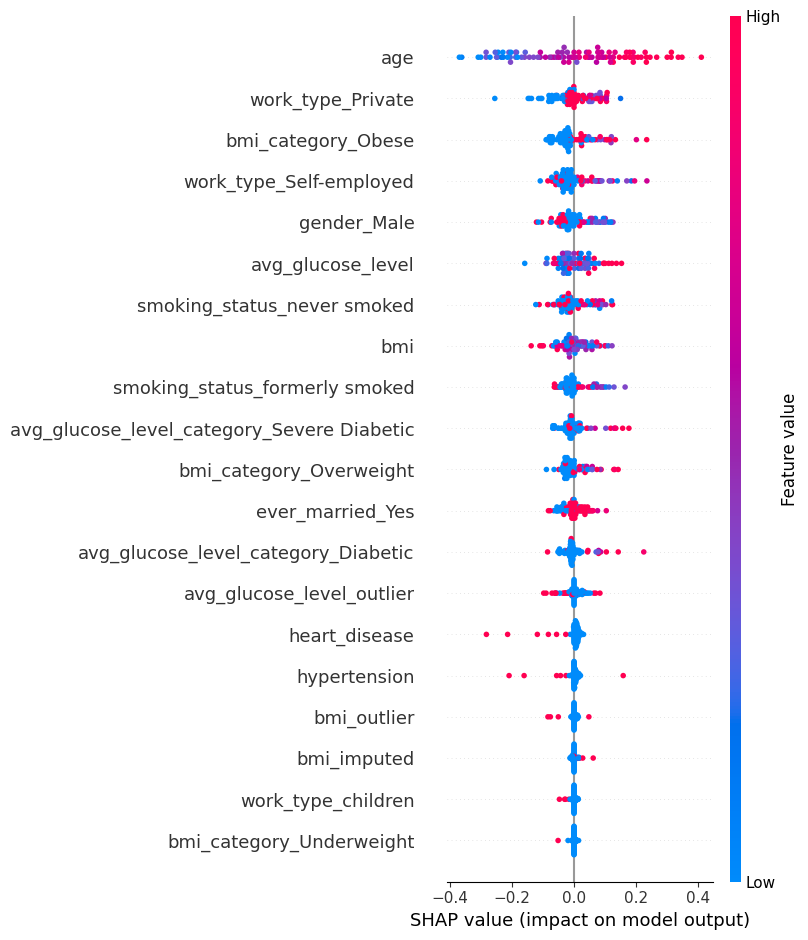

In [63]:
shap.summary_plot(shap_values, X_test_sample, show=True)

In [91]:
def evaluate_model(model, X_test, y_test, model_name = 'Model'):
  y_pred_prob = model.predict_proba(X_test)[:, 1]

  optimal_threshold_roc, optimal_threshold_f1 = find_optimal_threshold(y_pred_prob, y_test)
  metrics = plot_evaluation_matrics(y_test, y_pred_prob, optimal_threshold_roc, model_name)

  return metrics, y_pred_prob

In [65]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True)
    }

    model = XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

In [ ]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

print("Best XGBoost Parameters:")
best_params_xgb = study_xgb.best_params
for key, value in best_params_xgb.items():
    print(f"{key}: {value}")

[I 2025-03-04 15:53:00,798] A new study created in memory with name: no-name-1b3f2e37-a8e2-4d9b-8b83-22ab7dc9526c
[I 2025-03-04 15:53:04,627] Trial 0 finished with value: 0.9875890537081471 and parameters: {'max_depth': 9, 'learning_rate': 0.010380907385270557, 'n_estimators': 151, 'min_child_weight': 10, 'subsample': 0.979194477523071, 'colsample_bytree': 0.973528376426183, 'gamma': 4.002123693258711, 'reg_lambda': 0.0032938946007703257}. Best is trial 0 with value: 0.9875890537081471.
[I 2025-03-04 15:53:06,451] Trial 1 finished with value: 0.9883366243221804 and parameters: {'max_depth': 4, 'learning_rate': 0.023078347222859508, 'n_estimators': 191, 'min_child_weight': 5, 'subsample': 0.748840188732101, 'colsample_bytree': 0.8749615754090864, 'gamma': 3.6417859439438516, 'reg_lambda': 0.002761622006419051}. Best is trial 1 with value: 0.9883366243221804.
[I 2025-03-04 15:53:10,058] Trial 2 finished with value: 0.9917260352228331 and parameters: {'max_depth': 9, 'learning_rate': 0.01

Best XGBoost Parameters:
max_depth: 10
learning_rate: 0.047112738540263856
n_estimators: 83
min_child_weight: 2
subsample: 0.9482598645060588
colsample_bytree: 0.6044888590717954
gamma: 0.69712721535732
reg_lambda: 0.006862236245859257


In [66]:
with open('best_params_xgb.pkl', 'rb') as f:
    best_params_xgb = pickle.load(f)

print("Loaded Best Parameters:")
for key, value in best_params_xgb.items():
    print(f"{key}: {value}")

Loaded Best Parameters:
max_depth: 10
learning_rate: 0.047112738540263856
n_estimators: 83
min_child_weight: 2
subsample: 0.9482598645060588
colsample_bytree: 0.6044888590717954
gamma: 0.69712721535732
reg_lambda: 0.006862236245859257


Optimal threshold (ROC Youden's J): 0.5021
Optimal threshold (F1-score): 0.4807
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       964
           1       0.99      0.96      0.97       964

    accuracy                           0.97      1928
   macro avg       0.97      0.97      0.97      1928
weighted avg       0.97      0.97      0.97      1928



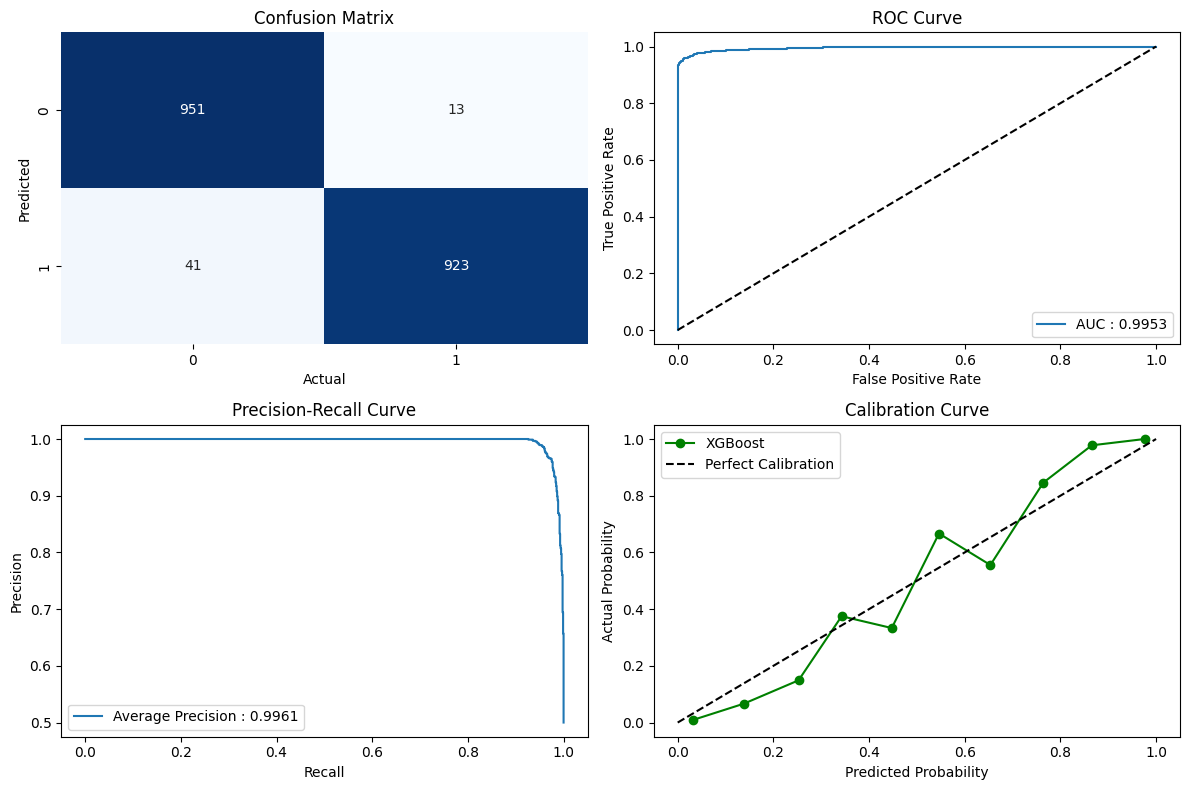

In [119]:
xgb_model = XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_metrics, xgb_pred_prob = evaluate_model(xgb_model, X_test_scaled, y_test, 'XGBoost')

Optimal threshold (ROC Youden's J): 0.5021
Optimal threshold (F1-score): 0.4807
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       964
           1       0.99      0.96      0.97       964

    accuracy                           0.97      1928
   macro avg       0.97      0.97      0.97      1928
weighted avg       0.97      0.97      0.97      1928



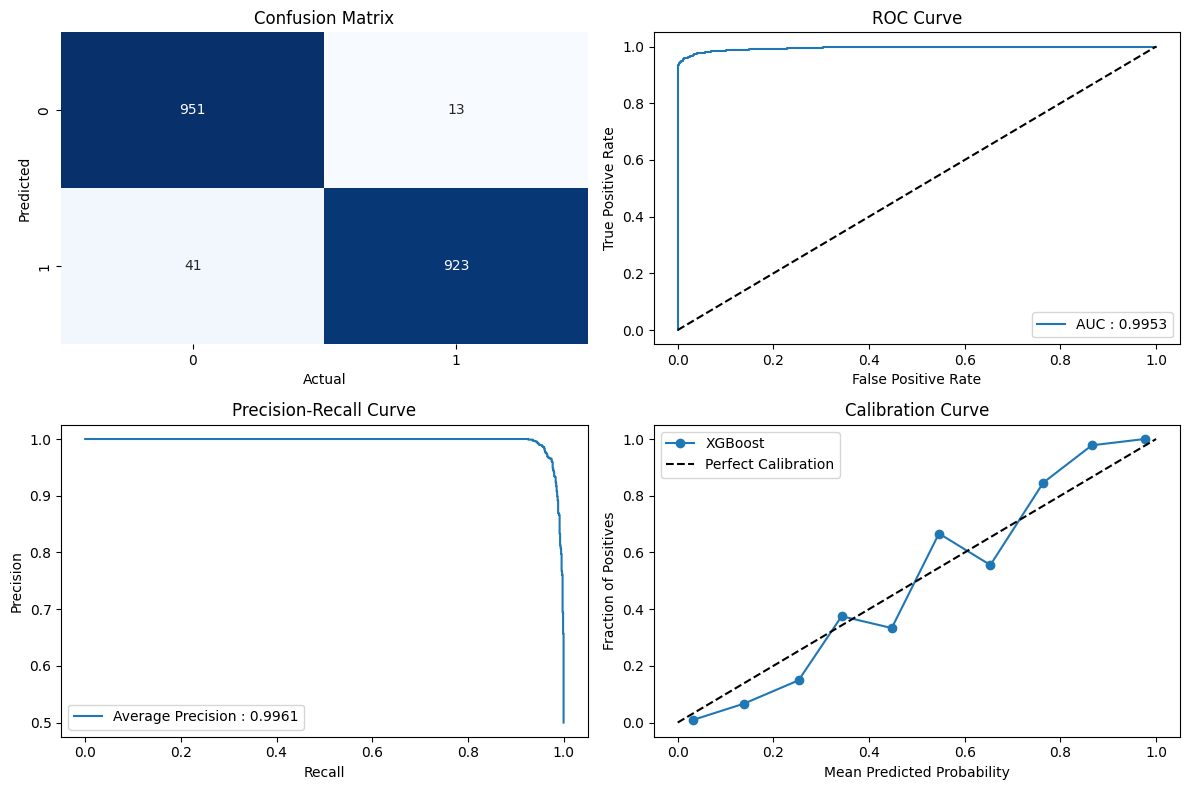

In [78]:
xgb_model = joblib.load('xgb_model.pkl')
xgb_metrics, xgb_pred_prob = evaluate_model(xgb_model, X_test_scaled, y_test, 'XGBoost')

In [68]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    model = RandomForestClassifier(**params, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

In [ ]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

print("Best Random Forest Parameters:")
best_params_rf = study_rf.best_params
for key, value in best_params_rf.items():
    print(f"{key}: {value}")

[I 2025-03-04 17:25:53,514] A new study created in memory with name: no-name-979ccbbe-b335-4cb9-83b8-c430f4f3c2f4
[I 2025-03-04 17:26:26,283] Trial 0 finished with value: 0.9929658371391022 and parameters: {'n_estimators': 273, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.9929658371391022.
[I 2025-03-04 17:26:29,975] Trial 1 finished with value: 0.9896234202964054 and parameters: {'n_estimators': 114, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9929658371391022.
[I 2025-03-04 17:26:31,873] Trial 2 finished with value: 0.976654849824315 and parameters: {'n_estimators': 71, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9929658371391022.
[I 2025-03-04 17:26:35,666] Trial 3 finished with value: 0.9943315314221761 and parameters: {'n_estimators': 97, 'max_depth': 20, 'min_sam

Best Random Forest Parameters:
n_estimators: 101
max_depth: 16
min_samples_split: 4
min_samples_leaf: 3
max_features: log2


In [69]:
with open('best_params_rf.pkl', 'rb') as f:
    best_params_rf = pickle.load(f)

print("Loaded Best Parameters:")
for key, value in best_params_rf.items():
    print(f"{key}: {value}")

Loaded Best Parameters:
n_estimators: 101
max_depth: 16
min_samples_split: 4
min_samples_leaf: 3
max_features: log2


Optimal threshold (ROC Youden's J): 0.5108
Optimal threshold (F1-score): 0.5108
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       964
           1       0.99      0.96      0.98       964

    accuracy                           0.98      1928
   macro avg       0.98      0.98      0.98      1928
weighted avg       0.98      0.98      0.98      1928



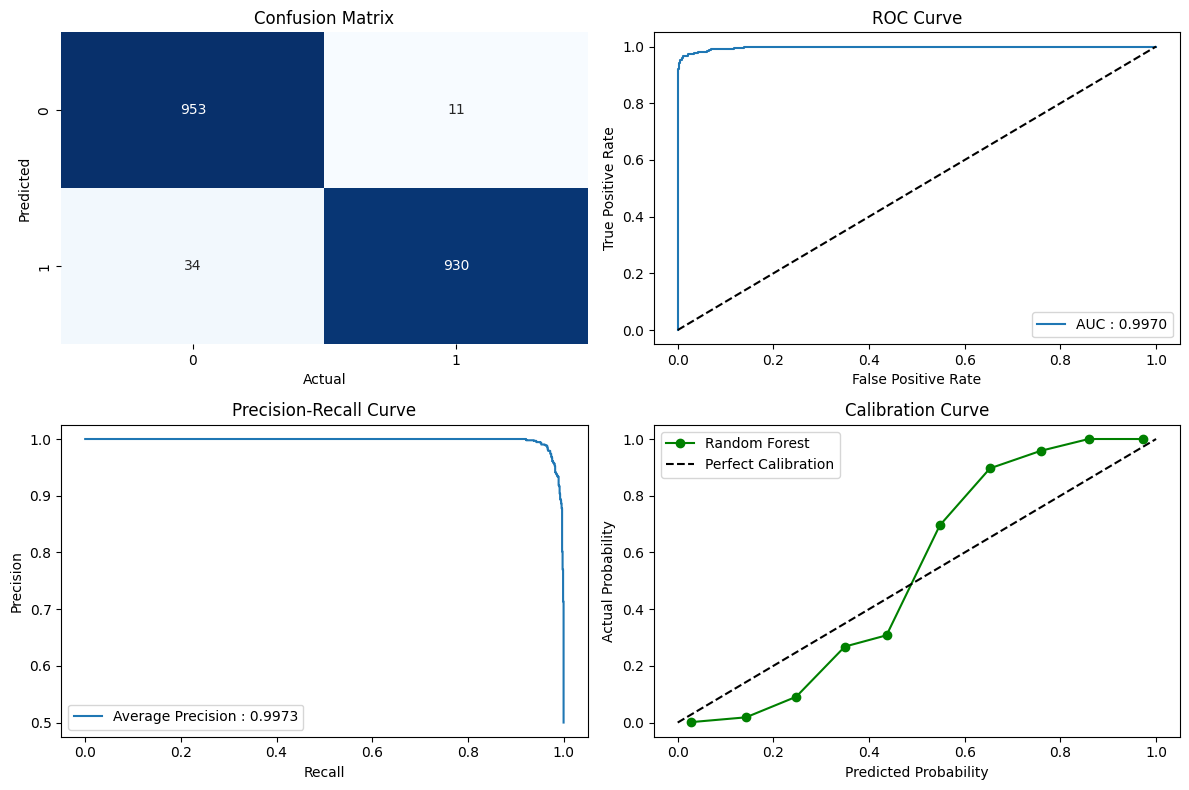

In [120]:
rf_model = RandomForestClassifier(**best_params_rf, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_metrics, rf_pred_prob = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

Optimal threshold (ROC Youden's J): 0.5108
Optimal threshold (F1-score): 0.5108
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       964
           1       0.99      0.96      0.98       964

    accuracy                           0.98      1928
   macro avg       0.98      0.98      0.98      1928
weighted avg       0.98      0.98      0.98      1928



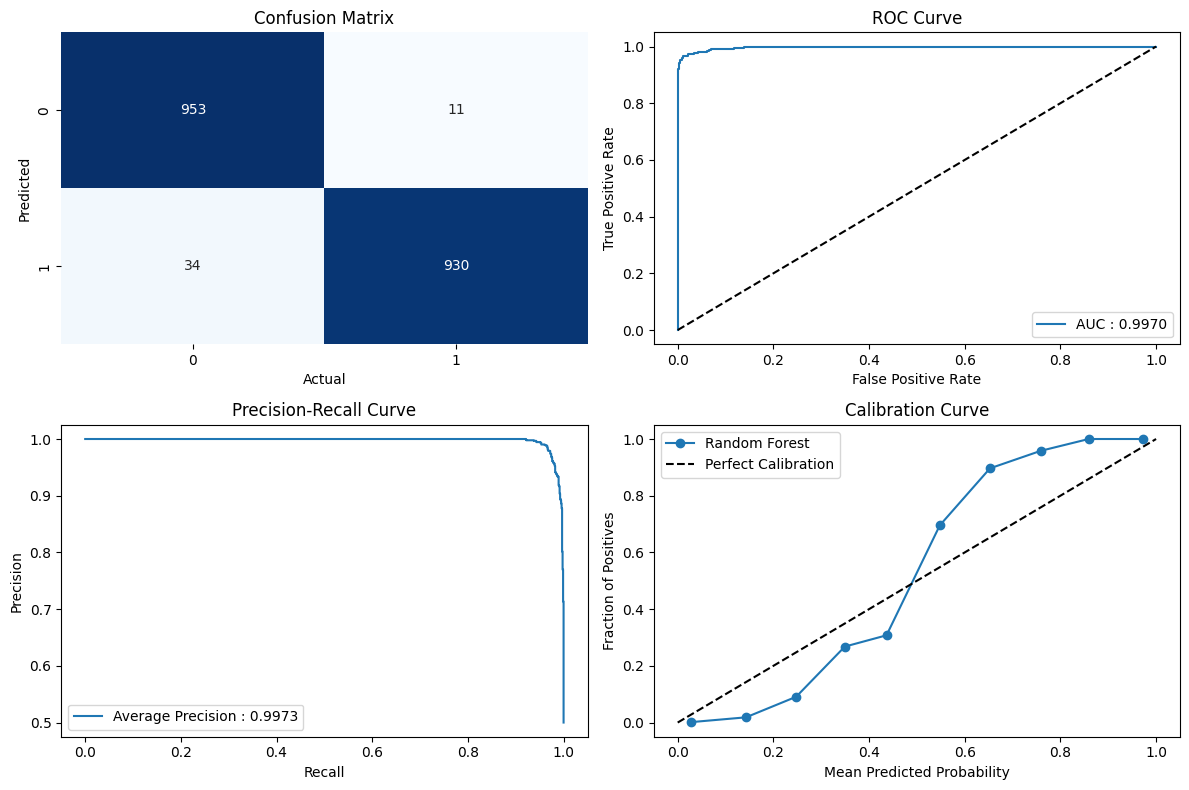

In [70]:
rf_model = joblib.load('rf_model.pkl')
rf_metrics, rf_pred_prob = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

In [ ]:
def objective_lr(trial):
    params = {
        'C': trial.suggest_float('C', 1e-4, 10, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga'])
    }

    model = LogisticRegression(**params, random_state=42, max_iter=1000)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

In [ ]:
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=30)

print("Best Logistic Regression Parameters:")
best_params_lr = study_lr.best_params
for key, value in best_params_lr.items():
    print(f"{key}: {value}")

[I 2025-03-04 17:42:01,855] A new study created in memory with name: no-name-292844fe-974e-4356-9079-6b6872b2cb09
[I 2025-03-04 17:42:02,646] Trial 0 finished with value: 0.8716696858733831 and parameters: {'C': 2.5900890787173267, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.8716696858733831.
[I 2025-03-04 17:42:02,926] Trial 1 finished with value: 0.871545412838695 and parameters: {'C': 0.4706302655401088, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8716696858733831.
[I 2025-03-04 17:42:03,200] Trial 2 finished with value: 0.8615742114762538 and parameters: {'C': 0.004728133972557889, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8716696858733831.
[I 2025-03-04 17:42:03,470] Trial 3 finished with value: 0.8608025140808377 and parameters: {'C': 0.004119469791638185, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8716696858733831.
[I 2025-03-04 17:42:03,677] Trial 4 finished with value: 0.8

Best Logistic Regression Parameters:
C: 2.0660191114105437
penalty: l2
solver: saga


In [71]:
with open('best_params_lr.pkl', 'rb') as f:
    best_params_lr = pickle.load(f)

print("Loaded Best Parameters:")
for key, value in best_params_lr.items():
    print(f"{key}: {value}")

Loaded Best Parameters:
C: 2.0660191114105437
penalty: l2
solver: saga


Optimal threshold (ROC Youden's J): 0.4877
Optimal threshold (F1-score): 0.4639
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       964
           1       0.79      0.85      0.82       964

    accuracy                           0.81      1928
   macro avg       0.81      0.81      0.81      1928
weighted avg       0.81      0.81      0.81      1928



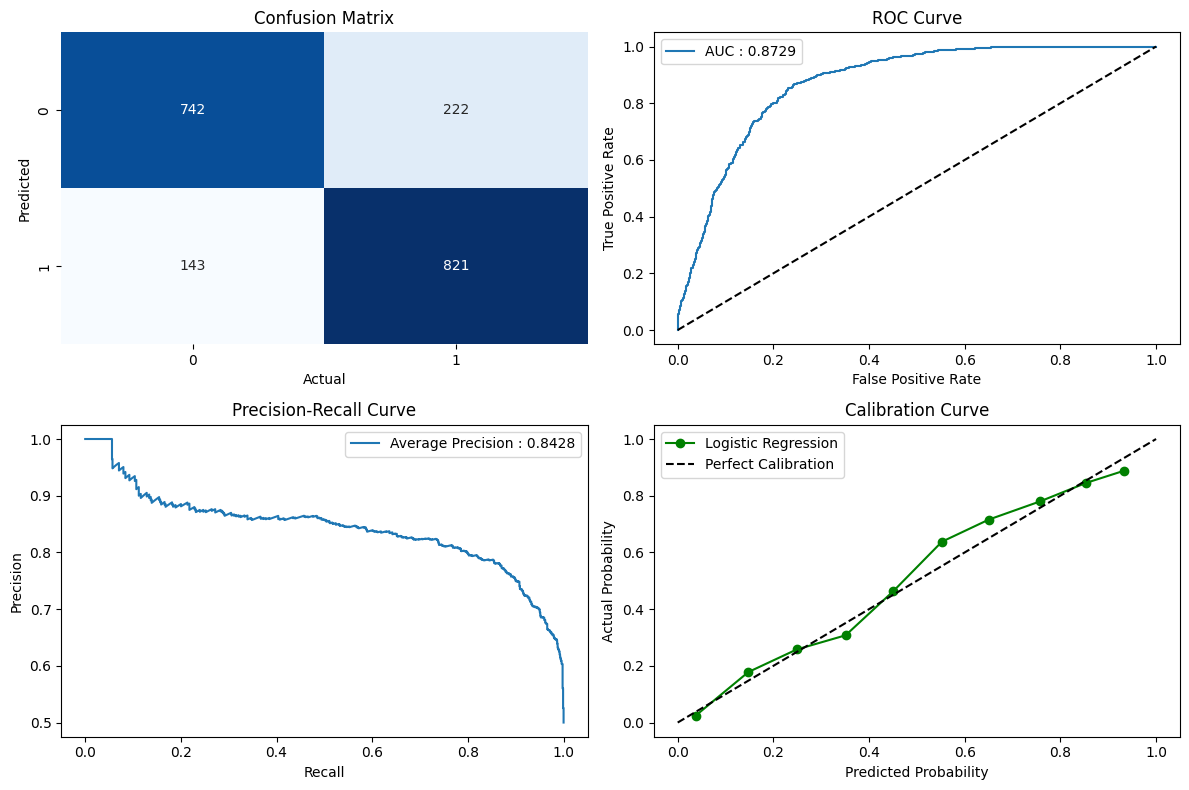

In [121]:
lr_model = LogisticRegression(**best_params_lr, random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_metrics, lr_pred_prob = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

Optimal threshold (ROC Youden's J): 0.4877
Optimal threshold (F1-score): 0.4639
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       964
           1       0.79      0.85      0.82       964

    accuracy                           0.81      1928
   macro avg       0.81      0.81      0.81      1928
weighted avg       0.81      0.81      0.81      1928



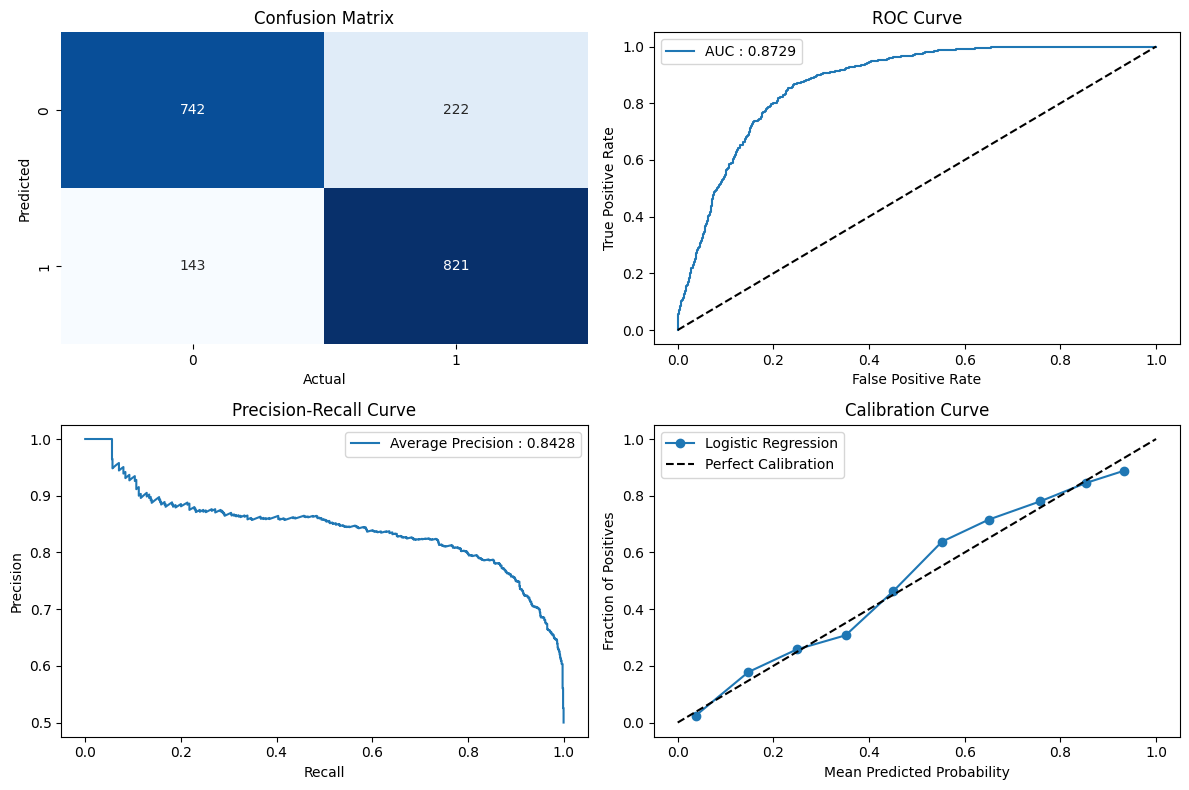

In [72]:
lr_model = joblib.load('lr_model.pkl')
lr_metrics, lr_pred_prob = evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")

In [122]:
nn_metrics = evaluation_metrics
nn_pred_prob = nn_model.predict(X_test_scaled).flatten()

models_metrics = {
    "Neural Network": nn_metrics,
    "XGBoost": xgb_metrics,
    "Random Forest": rf_metrics,
    "Logistic Regression": lr_metrics
}

metrics_df = pd.DataFrame(models_metrics).T
print("\nModel Comparison:")
metrics_df

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Model Comparison:


accuracy  precision    recall        f1       auc  \
Neural Network       0.953320   0.943205  0.964730  0.953846  0.989483   
XGBoost              0.971992   0.986111  0.957469  0.971579  0.995290   
Random Forest        0.976660   0.988310  0.964730  0.976378  0.996978   
Logistic Regression  0.810685   0.787152  0.851660  0.818137  0.872865   

                     avg_precision  
Neural Network            0.989564  
XGBoost                   0.996051  
Random Forest             0.997319  
Logistic Regression       0.842829

<Figure size 1200x600 with 0 Axes>

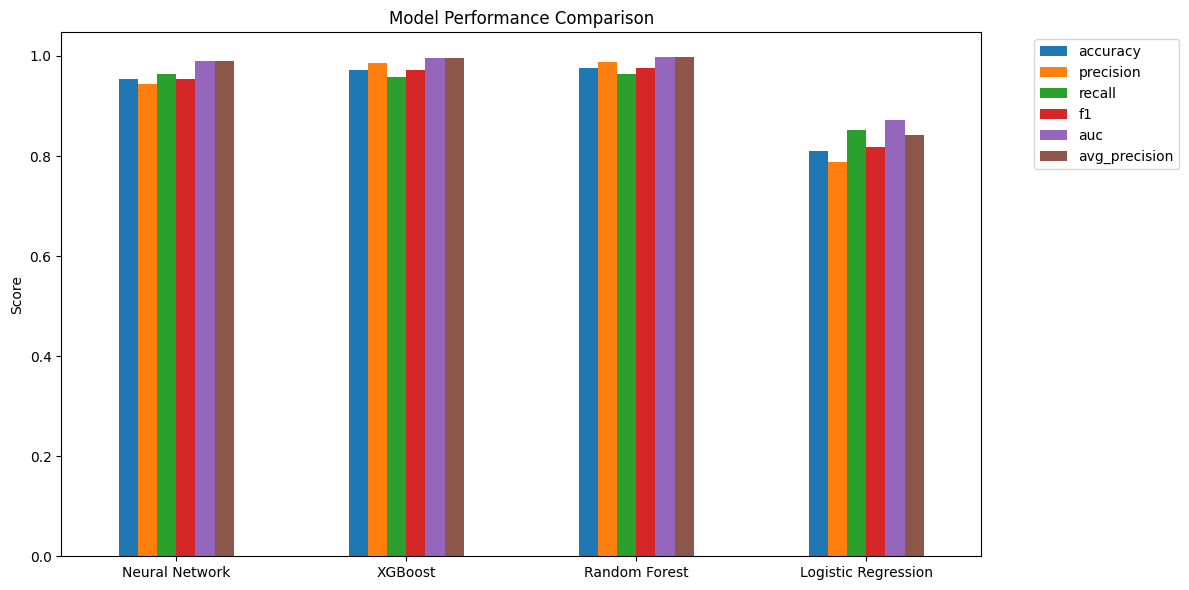

In [123]:
plt.figure(figsize=(12, 6))
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


XGBoost Calibration Results:
Brier Score Before: 0.0229
Brier Score After: 0.0244
ECE Before: 0.0330
ECE After: 0.0120
Optimal threshold (ROC Youden's J): 0.7895
Optimal threshold (F1-score): 0.7895
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       964
           1       0.99      0.95      0.97       964

    accuracy                           0.97      1928
   macro avg       0.97      0.97      0.97      1928
weighted avg       0.97      0.97      0.97      1928



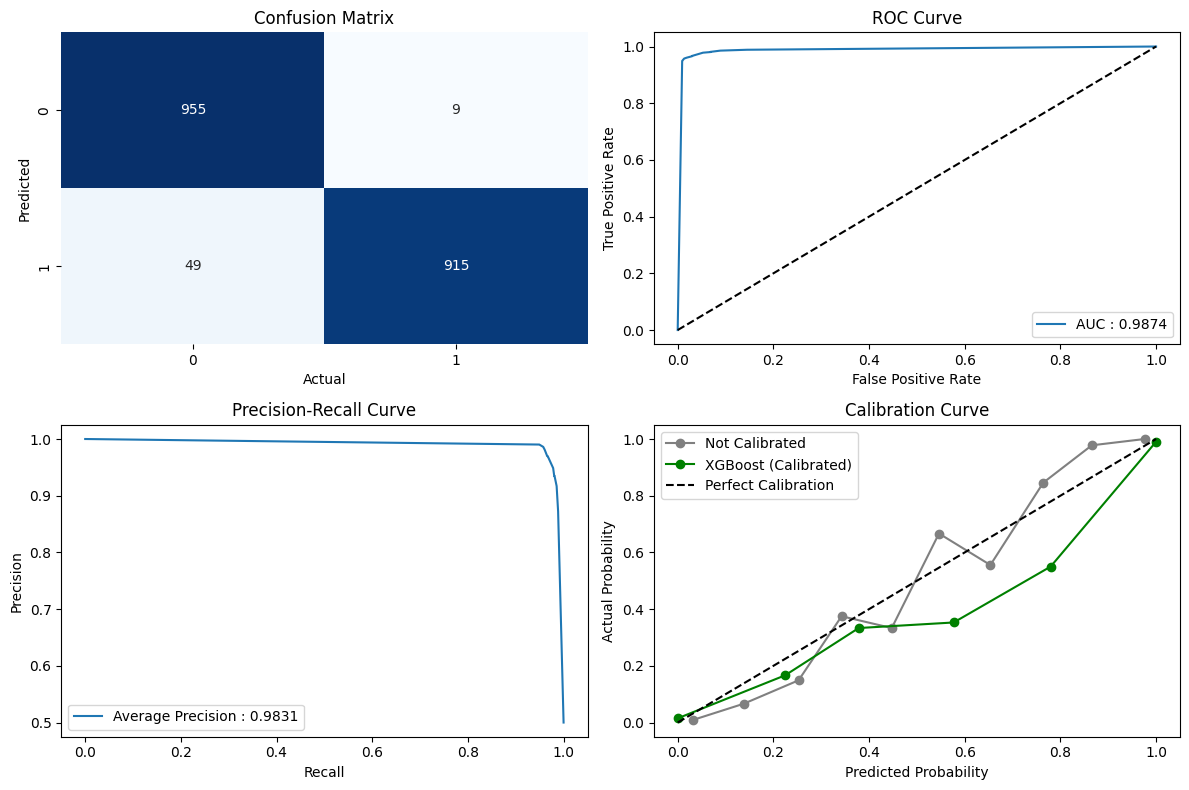


Random Forest Calibration Results:
Brier Score Before: 0.0254
Brier Score After: 0.0217
ECE Before: 0.0583
ECE After: 0.0157
Optimal threshold (ROC Youden's J): 0.8148
Optimal threshold (F1-score): 0.8148
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       964
           1       0.99      0.96      0.97       964

    accuracy                           0.97      1928
   macro avg       0.98      0.97      0.97      1928
weighted avg       0.98      0.97      0.97      1928



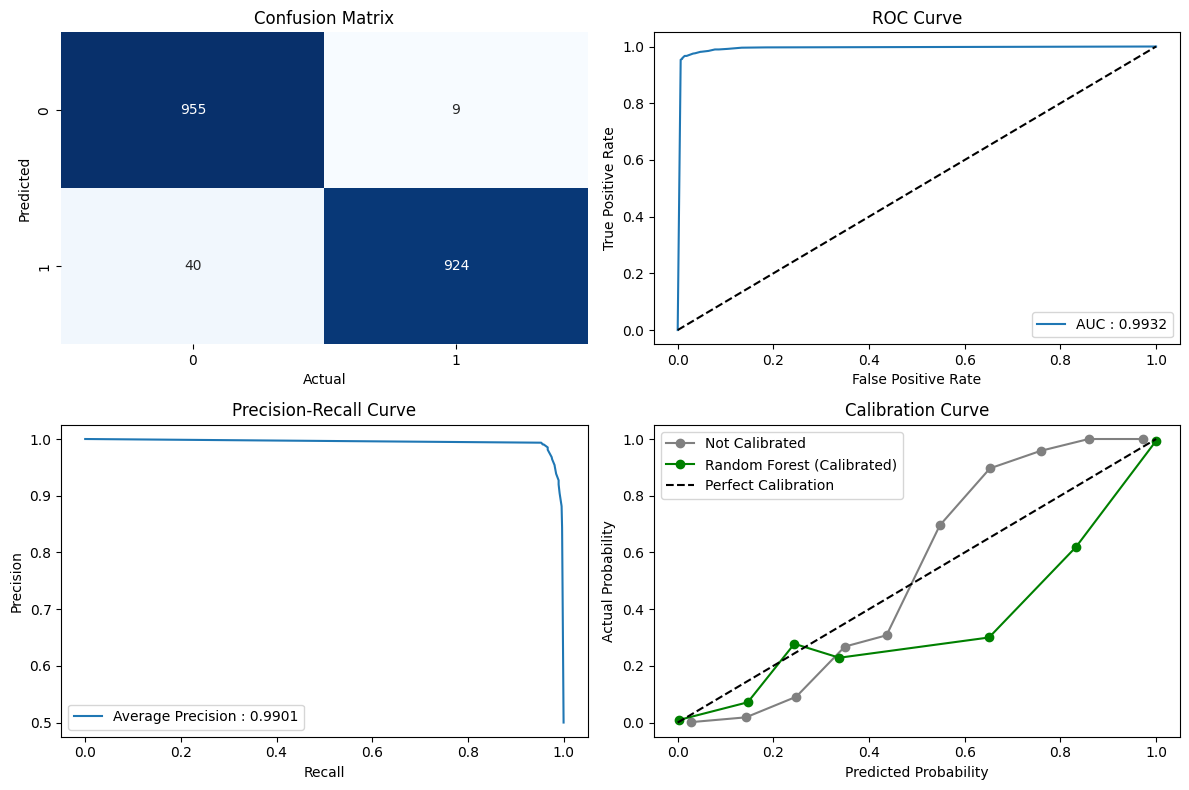


Logistic Regression Calibration Results:
Brier Score Before: 0.1411
Brier Score After: 0.1405
ECE Before: 0.0293
ECE After: 0.0245
Optimal threshold (ROC Youden's J): 0.5062
Optimal threshold (F1-score): 0.5062
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       964
           1       0.78      0.85      0.82       964

    accuracy                           0.81      1928
   macro avg       0.81      0.81      0.81      1928
weighted avg       0.81      0.81      0.81      1928



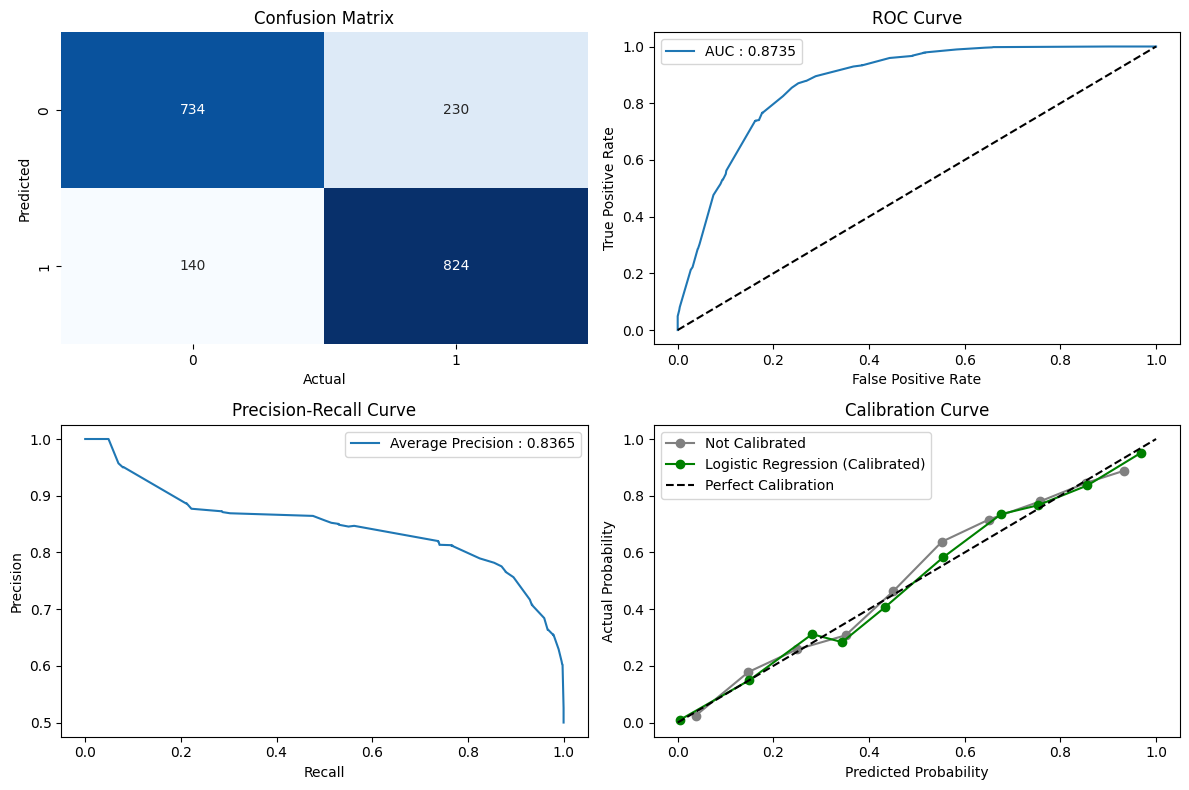

In [134]:
X_train_cal, X_calib, y_train_cal, y_calib = train_test_split(X_train_scaled, y_train, test_size = 0.5, random_state = 42, stratify = y_train)

models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Logistic Regression": lr_model
}

calibrated_models = {}
for name, model, in models.items():
  y_pred_prob_cal = model.predict_proba(X_calib)[:, 1]

  calibrator = IsotonicRegression(out_of_bounds='clip')
  calibrator.fit(y_pred_prob_cal, y_calib)

  y_pred_prob_test = model.predict_proba(X_test_scaled)[:, 1]
  calibrated_probs_test = calibrator.predict(y_pred_prob_test)

  print(f"\n{name} Calibration Results:")
  brier_before = brier_score_loss(y_test, y_pred_prob_test)
  brier_after = brier_score_loss(y_test, calibrated_probs_test)
  print(f"Brier Score Before: {brier_before:.4f}")
  print(f"Brier Score After: {brier_after:.4f}")

  ece_before = expected_calibration_error(y_test, y_pred_prob_test)
  ece_after = expected_calibration_error(y_test, calibrated_probs_test)
  print(f"ECE Before: {ece_before:.4f}")
  print(f"ECE After: {ece_after:.4f}")

  optimal_threshold_roc_cal, _ = find_optimal_threshold(calibrated_probs_test, y_test)
  calibrated_metrics = plot_evaluation_matrics(y_test, calibrated_probs_test, optimal_threshold_roc_cal, f"{name} (Calibrated)", y_pred_prob_test)
  calibrated_models[name] = calibrated_metrics

In [135]:
calibrated_metrics_df = pd.DataFrame(calibrated_models).T
calibrated_metrics_df.loc["Neural Network (Calibrated)"] = evaluation_metrics_calibrated
print("\nCalibrated Model Comparison:")
calibrated_metrics_df


Calibrated Model Comparison:


accuracy  precision    recall       f1       auc  \
XGBoost                      0.969917   0.990260  0.949170  0.96928  0.987359   
Random Forest                0.974585   0.990354  0.958506  0.97417  0.993180   
Logistic Regression          0.808091   0.781784  0.854772  0.81665  0.873493   
Neural Network (Calibrated)  0.950207   0.934870  0.967842  0.95107  0.981484   

                             avg_precision  
XGBoost                           0.983147  
Random Forest                     0.990124  
Logistic Regression               0.836539  
Neural Network (Calibrated)       0.974995

<Figure size 1200x600 with 0 Axes>

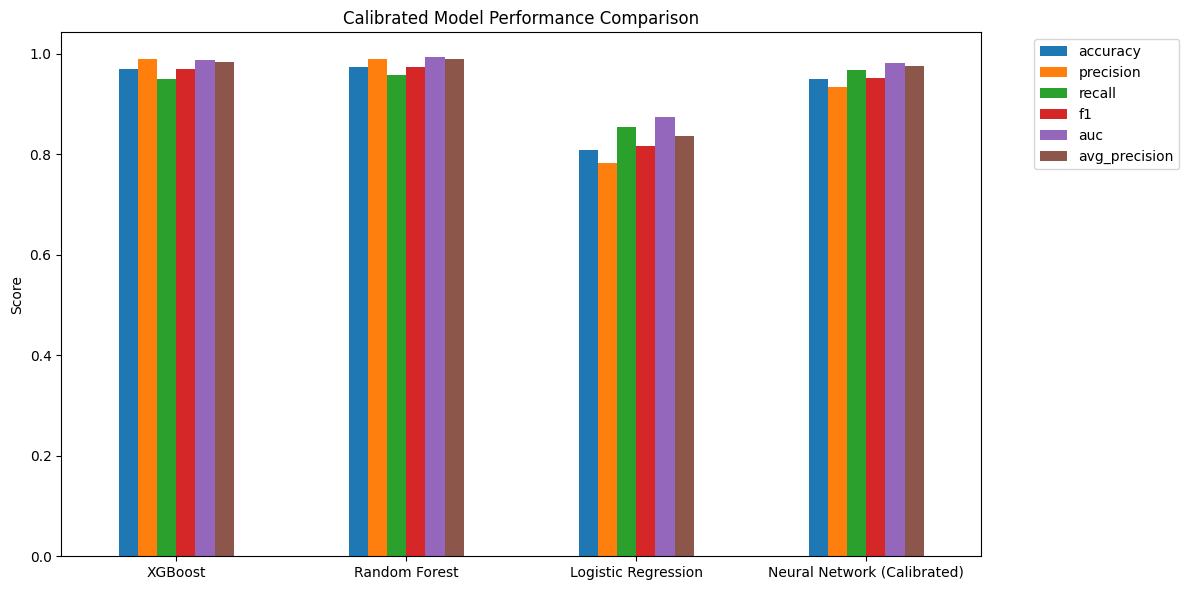

In [136]:
plt.figure(figsize=(12, 6))
calibrated_metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Calibrated Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [138]:
def predict_fn_xgb(X):
  return xgb_model.predict_proba(X)[:, 1]

explainer = shap.KernelExplainer(predict_fn_xgb, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

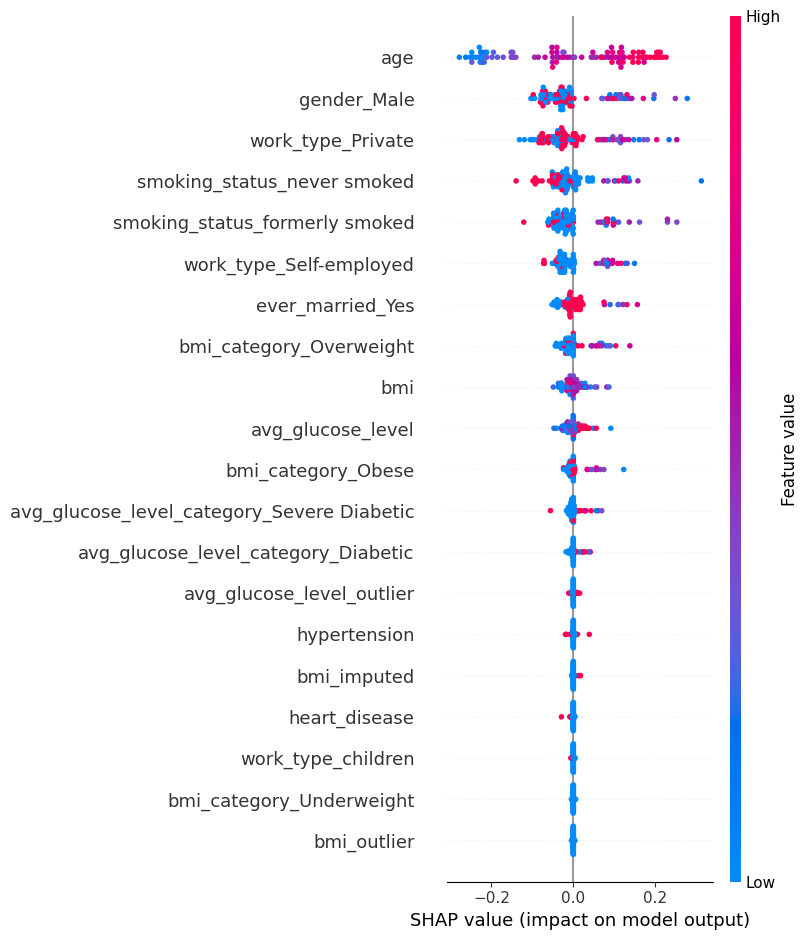

In [139]:
shap.summary_plot(shap_values, X_test_sample, show = True)

In [145]:
def rf_predict_fn(X):
  calibrator = IsotonicRegression(out_of_bounds='clip')
  pred_prob_calib = rf_model.predict_proba(X_calib)[:, 1]
  calibrator.fit(pred_prob_calib, y_calib)

  y_pred_prob_test = rf_model.predict_proba(X)[:, 1]
  calibrated_probs_test = calibrator.predict(y_pred_prob_test)
  return calibrated_probs_test

explainer = shap.KernelExplainer(rf_predict_fn, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

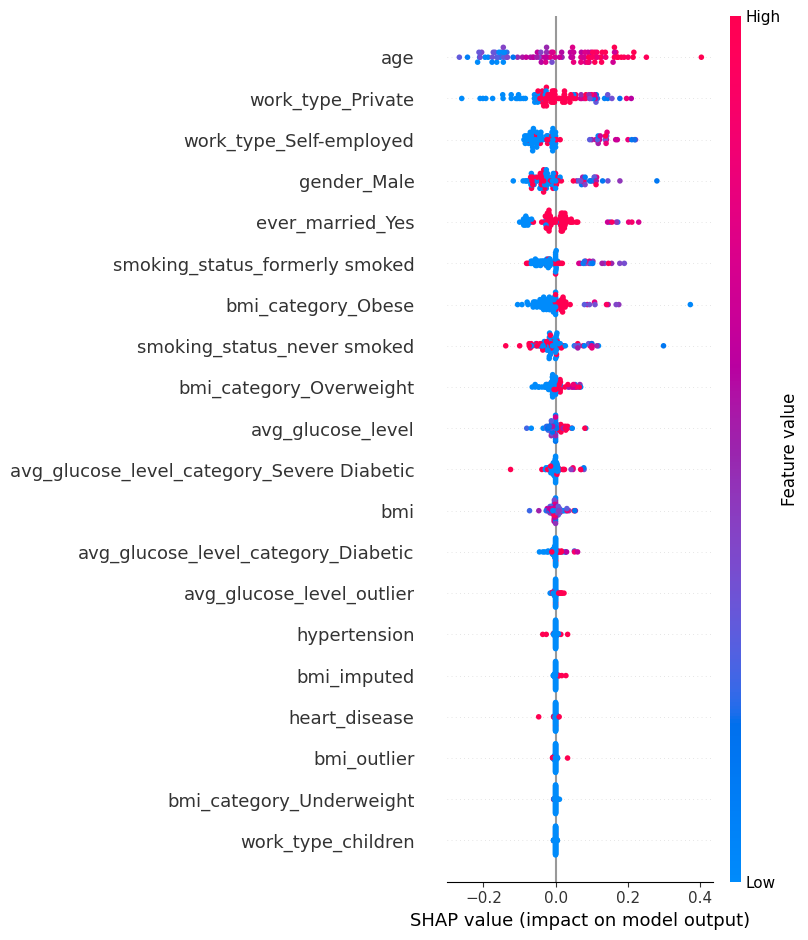

In [146]:
shap.summary_plot(shap_values, X_test_sample, show = True)

In [147]:
def lr_predict_fn(X):
  calibrator = IsotonicRegression(out_of_bounds='clip')
  pred_prob_calib = lr_model.predict_proba(X_calib)[:, 1]
  calibrator.fit(pred_prob_calib, y_calib)

  y_pred_prob_test = lr_model.predict_proba(X)[:, 1]
  calibrated_probs_test = calibrator.predict(y_pred_prob_test)
  return calibrated_probs_test

explainer = shap.KernelExplainer(rf_predict_fn, X_test_sample)
shap_values = explainer.shap_values(X_test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

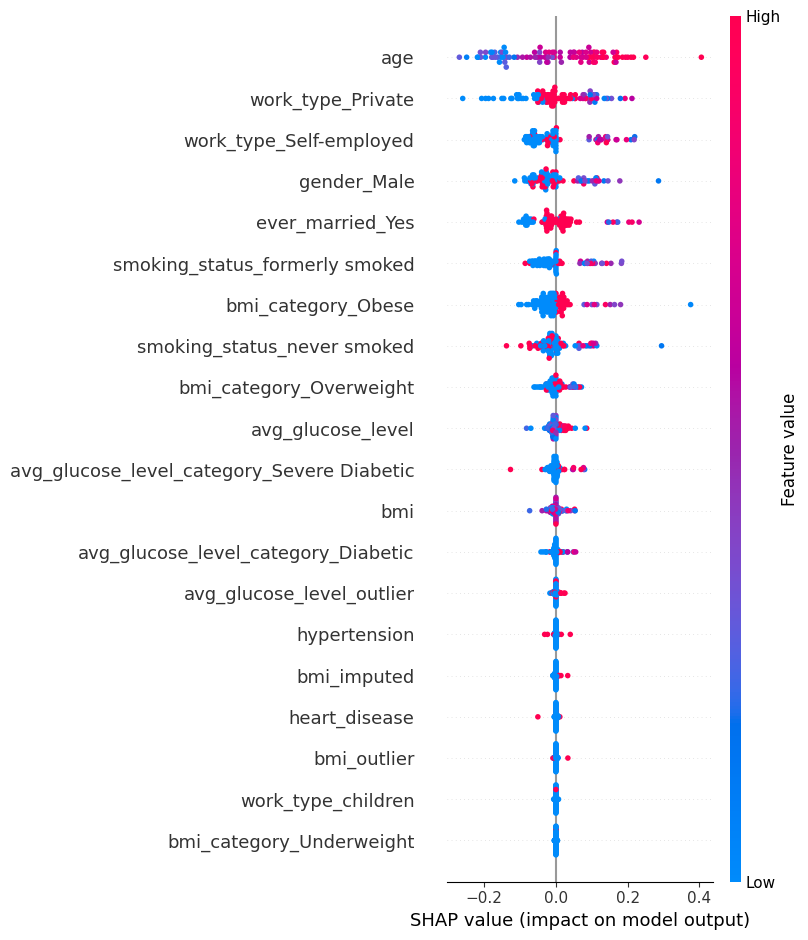

In [148]:
shap.summary_plot(shap_values, X_test_sample, show = True)

In [ ]:
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(lr_model, 'lr_model.pkl')

['lr_model.pkl']

In [ ]:
with open('best_params_xgb.pkl', 'wb') as f:
    pickle.dump(best_params_xgb, f)

with open('best_params_rf.pkl', 'wb') as f:
    pickle.dump(best_params_rf, f)

with open('best_params_lr.pkl', 'wb') as f:
    pickle.dump(best_params_lr, f)

In [ ]:
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [ ]:
with open('best_params_nn.pkl', 'wb') as f:
    pickle.dump(best_params, f)

In [ ]:
nn_model.save('optimized_model_nn.keras')

In [ ]:
history_df = pd.DataFrame(history)
history_df.to_csv('nn_training_history.csv', index=False)